!pip install python_speech_features

In [1]:
from os import listdir
from os.path import isdir, join

# os: listdir- count the directory files.
# isdir: to check for confirmation of existence of file.
# join to make the successful path connection 

In [2]:
import librosa
# load wav file

In [3]:
import random
# so that the random files are divided in train, text, validation set.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# make the mfcc graph

In [5]:
import python_speech_features
# used in feature ecxtraction

In [6]:
from tensorflow.keras import layers, models
#CNN model.
import numpy as np

In [7]:
# Dataset path and view possible targets
dataset_path = 'H://AI//capstone_project//NewMethod//mini_speech_commands'
i=0
dict={}
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        dict[i]=name
        i+=1

In [8]:
# Create list of an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'left', 'nine', 'no', 'off', 'one', 'right', 'seven', 'six', 'stop', 'three', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [9]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

1020
1060
1026
1040
1020
1000
1003
1004
1073
1029
1007
1000
1014
1013
1000
1042
1000
1029
1000
1000
1053
1010
1000
1028
1022
1000
1056
1022
1000
1000
Total samples: 30571


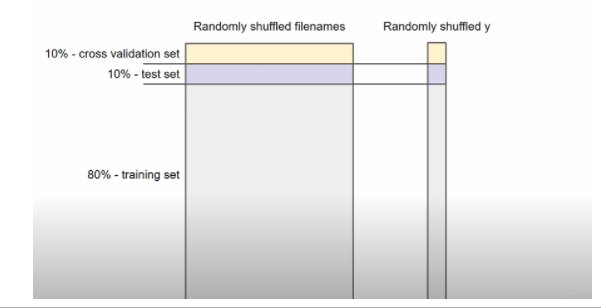

In [10]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.05
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 20
len_mfcc = 20

In [11]:
# Create list of filenames along with ground truth vector (y)- original index.
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)


H://AI//capstone_project//NewMethod//mini_speech_commands\backward
H://AI//capstone_project//NewMethod//mini_speech_commands\bed
H://AI//capstone_project//NewMethod//mini_speech_commands\bird
H://AI//capstone_project//NewMethod//mini_speech_commands\cat
H://AI//capstone_project//NewMethod//mini_speech_commands\dog
H://AI//capstone_project//NewMethod//mini_speech_commands\down
H://AI//capstone_project//NewMethod//mini_speech_commands\eight
H://AI//capstone_project//NewMethod//mini_speech_commands\five
H://AI//capstone_project//NewMethod//mini_speech_commands\follow
H://AI//capstone_project//NewMethod//mini_speech_commands\forward
H://AI//capstone_project//NewMethod//mini_speech_commands\four
H://AI//capstone_project//NewMethod//mini_speech_commands\go
H://AI//capstone_project//NewMethod//mini_speech_commands\happy
H://AI//capstone_project//NewMethod//mini_speech_commands\house
H://AI//capstone_project//NewMethod//mini_speech_commands\left
H://AI//capstone_project//NewMethod//mini_speech

# Check ground truth Y vector
for item in y:
    print(len(item))

In [12]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [13]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [14]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

30571
30571


MFCC: Transforming audio into Mel Frequency Cepstral Coefficients.
 
 To find MFCC take a small time in the audio and find the fast FT so that we get the freq of that time slice. Then apply the filters to that fast fourier transform spectrum. The filters are linearly spaced below 1KHz and lograthmically spaced above 1KHz. Then sum up the power found in each slice of filter to get a number representig the energy under that fitler. 
 
 Ususally MFCC uses 26 filters for voice.Compute the log of each filter in the vector and calculate the dct of each bank energies.At end we get 26 MFCC(if the initial vectors taken is 26).
 
 For speech we dont walt the 0 element and all the elements after element 13 as after 13 it is usually noise 
    
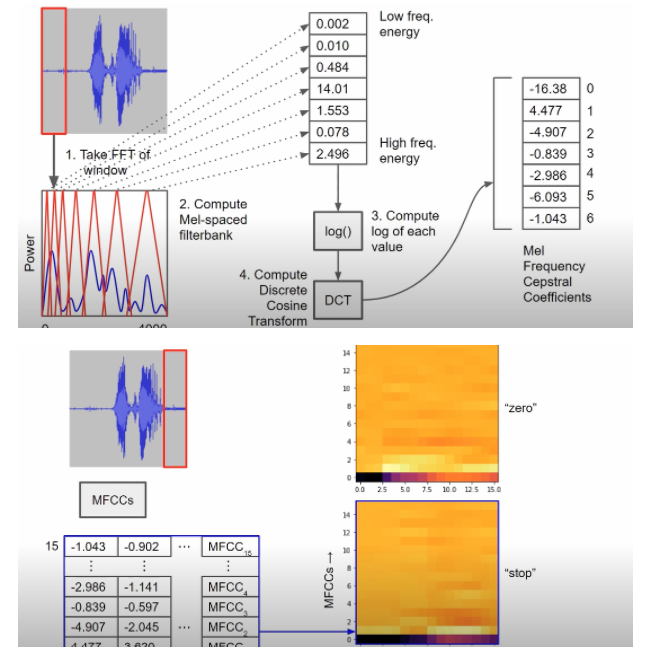

In [15]:
# Calculate length of validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [16]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [17]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [18]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile and resample it at 8000Hz
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    #create set of MFCC from sound clip
    
    # no of MFCC is low , 
    # therefore winlen is kept low(256millisec), 
    # increase the distance between windows to 50 milli second.,
    # taking the first 16 mfcc,
    # no of filters: 26,
    #  FFT (fast fourier transform ) size: 2048( high becoz no of window are low.)
    # preemph, ceplifter – apply preemphasis filter, liftering(here, disabled)
    # winfunc – the analysis window to apply to each frame
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [19]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1

Dropped: 0 (20, 16)
Dropped: 1 (20, 9)
Dropped: 2 (20, 12)
Dropped: 3 (20, 10)
Dropped: 4 (20, 12)
Dropped: 5 (20, 16)
Dropped: 6 (20, 16)
Dropped: 7 (20, 9)
Dropped: 8 (20, 10)
Dropped: 9 (20, 12)
Dropped: 10 (20, 16)
Dropped: 11 (20, 7)
Dropped: 12 (20, 10)
Dropped: 13 (20, 6)
Dropped: 14 (20, 16)
Dropped: 15 (20, 16)
Dropped: 16 (20, 15)
Dropped: 17 (20, 16)
Dropped: 18 (20, 8)
Dropped: 19 (20, 16)
Dropped: 20 (20, 8)
Dropped: 21 (20, 16)
Dropped: 22 (20, 16)
Dropped: 23 (20, 11)
Dropped: 24 (20, 7)
Dropped: 25 (20, 6)
Dropped: 26 (20, 16)
Dropped: 27 (20, 16)
Dropped: 28 (20, 16)
Dropped: 29 (20, 16)
Dropped: 30 (20, 9)
Dropped: 31 (20, 7)
Dropped: 32 (20, 16)
Dropped: 33 (20, 7)
Dropped: 34 (20, 16)
Dropped: 35 (20, 16)
Dropped: 36 (20, 16)
Dropped: 37 (20, 16)
Dropped: 38 (20, 16)
Dropped: 39 (20, 10)
Dropped: 40 (20, 16)
Dropped: 41 (20, 10)
Dropped: 42 (20, 16)
Dropped: 43 (20, 16)
Dropped: 44 (20, 16)
Dropped: 45 (20, 11)
Dropped: 46 (20, 16)
Dropped: 47 (20, 8)
Dropped: 48 (2

Dropped: 382 (20, 16)
Dropped: 383 (20, 12)
Dropped: 384 (20, 16)
Dropped: 385 (20, 9)
Dropped: 386 (20, 10)
Dropped: 387 (20, 6)
Dropped: 388 (20, 16)
Dropped: 389 (20, 7)
Dropped: 390 (20, 16)
Dropped: 391 (20, 16)
Dropped: 392 (20, 16)
Dropped: 393 (20, 10)
Dropped: 394 (20, 7)
Dropped: 395 (20, 16)
Dropped: 396 (20, 16)
Dropped: 397 (20, 16)
Dropped: 398 (20, 16)
Dropped: 399 (20, 15)
Dropped: 400 (20, 16)
Dropped: 401 (20, 6)
Dropped: 402 (20, 16)
Dropped: 403 (20, 15)
Dropped: 404 (20, 16)
Dropped: 405 (20, 16)
Dropped: 406 (20, 16)
Dropped: 407 (20, 13)
Dropped: 408 (20, 16)
Dropped: 409 (20, 16)
Dropped: 410 (20, 16)
Dropped: 411 (20, 9)
Dropped: 412 (20, 7)
Dropped: 413 (20, 16)
Dropped: 414 (20, 16)
Dropped: 415 (20, 16)
Dropped: 416 (20, 16)
Dropped: 417 (20, 6)
Dropped: 418 (20, 16)
Dropped: 419 (20, 16)
Dropped: 420 (20, 16)
Dropped: 421 (20, 6)
Dropped: 422 (20, 16)
Dropped: 423 (20, 16)
Dropped: 424 (20, 16)
Dropped: 425 (20, 16)
Dropped: 426 (20, 16)
Dropped: 427 (20, 1

In [20]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 1.0


three


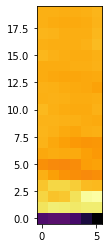

In [21]:
# TEST: Test shorter MFCC
#!pip install playsound
#from playsound import playsound


# to draw mfcc graph od word on index 13
idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
#print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
#playsound(path)

In [22]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [23]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))


Dropped: 0 (20, 16)
Dropped: 1 (20, 9)
Dropped: 2 (20, 12)
Dropped: 3 (20, 10)
Dropped: 4 (20, 12)
Dropped: 5 (20, 16)
Dropped: 6 (20, 16)
Dropped: 7 (20, 9)
Dropped: 8 (20, 10)
Dropped: 9 (20, 12)
Dropped: 10 (20, 16)
Dropped: 11 (20, 7)
Dropped: 12 (20, 10)
Dropped: 13 (20, 6)
Dropped: 14 (20, 16)
Dropped: 15 (20, 16)
Dropped: 16 (20, 15)
Dropped: 17 (20, 16)
Dropped: 18 (20, 8)
Dropped: 19 (20, 16)
Dropped: 20 (20, 8)
Dropped: 21 (20, 16)
Dropped: 22 (20, 16)
Dropped: 23 (20, 11)
Dropped: 24 (20, 7)
Dropped: 25 (20, 6)
Dropped: 26 (20, 16)
Dropped: 27 (20, 16)
Dropped: 28 (20, 16)
Dropped: 29 (20, 16)
Dropped: 30 (20, 9)
Dropped: 31 (20, 7)
Dropped: 32 (20, 16)
Dropped: 33 (20, 7)
Dropped: 34 (20, 16)
Dropped: 35 (20, 16)
Dropped: 36 (20, 16)
Dropped: 37 (20, 16)
Dropped: 38 (20, 16)
Dropped: 39 (20, 10)
Dropped: 40 (20, 16)
Dropped: 41 (20, 10)
Dropped: 42 (20, 16)
Dropped: 43 (20, 16)
Dropped: 44 (20, 16)
Dropped: 45 (20, 11)
Dropped: 46 (20, 16)
Dropped: 47 (20, 8)
Dropped: 48 (2

Dropped: 382 (20, 16)
Dropped: 383 (20, 12)
Dropped: 384 (20, 16)
Dropped: 385 (20, 9)
Dropped: 386 (20, 10)
Dropped: 387 (20, 6)
Dropped: 388 (20, 16)
Dropped: 389 (20, 7)
Dropped: 390 (20, 16)
Dropped: 391 (20, 16)
Dropped: 392 (20, 16)
Dropped: 393 (20, 10)
Dropped: 394 (20, 7)
Dropped: 395 (20, 16)
Dropped: 396 (20, 16)
Dropped: 397 (20, 16)
Dropped: 398 (20, 16)
Dropped: 399 (20, 15)
Dropped: 400 (20, 16)
Dropped: 401 (20, 6)
Dropped: 402 (20, 16)
Dropped: 403 (20, 15)
Dropped: 404 (20, 16)
Dropped: 405 (20, 16)
Dropped: 406 (20, 16)
Dropped: 407 (20, 13)
Dropped: 408 (20, 16)
Dropped: 409 (20, 16)
Dropped: 410 (20, 16)
Dropped: 411 (20, 9)
Dropped: 412 (20, 7)
Dropped: 413 (20, 16)
Dropped: 414 (20, 16)
Dropped: 415 (20, 16)
Dropped: 416 (20, 16)
Dropped: 417 (20, 6)
Dropped: 418 (20, 16)
Dropped: 419 (20, 16)
Dropped: 420 (20, 16)
Dropped: 421 (20, 6)
Dropped: 422 (20, 16)
Dropped: 423 (20, 16)
Dropped: 424 (20, 16)
Dropped: 425 (20, 16)
Dropped: 426 (20, 16)
Dropped: 427 (20, 1

Dropped: 758 (20, 16)
Dropped: 759 (20, 8)
Dropped: 760 (20, 8)
Dropped: 761 (20, 16)
Dropped: 762 (20, 16)
Dropped: 763 (20, 16)
Dropped: 764 (20, 16)
Dropped: 765 (20, 16)
Dropped: 766 (20, 16)
Dropped: 767 (20, 16)
Dropped: 768 (20, 16)
Dropped: 769 (20, 12)
Dropped: 770 (20, 16)
Dropped: 771 (20, 8)
Dropped: 772 (20, 16)
Dropped: 773 (20, 16)
Dropped: 774 (20, 16)
Dropped: 775 (20, 16)
Dropped: 776 (20, 11)
Dropped: 777 (20, 16)
Dropped: 778 (20, 11)
Dropped: 779 (20, 16)
Dropped: 780 (20, 16)
Dropped: 781 (20, 9)
Dropped: 782 (20, 16)
Dropped: 783 (20, 16)
Dropped: 784 (20, 16)
Dropped: 785 (20, 16)
Dropped: 786 (20, 15)
Dropped: 787 (20, 8)
Dropped: 788 (20, 16)
Dropped: 789 (20, 16)
Dropped: 790 (20, 11)
Dropped: 791 (20, 10)
Dropped: 792 (20, 9)
Dropped: 793 (20, 16)
Dropped: 794 (20, 16)
Dropped: 795 (20, 4)
Dropped: 796 (20, 16)
Dropped: 797 (20, 10)
Dropped: 798 (20, 16)
Dropped: 799 (20, 8)
Dropped: 800 (20, 16)
Dropped: 801 (20, 16)
Dropped: 802 (20, 12)
Dropped: 803 (20, 

Dropped: 1129 (20, 10)
Dropped: 1130 (20, 16)
Dropped: 1131 (20, 6)
Dropped: 1132 (20, 9)
Dropped: 1133 (20, 9)
Dropped: 1134 (20, 16)
Dropped: 1135 (20, 9)
Dropped: 1136 (20, 10)
Dropped: 1137 (20, 16)
Dropped: 1138 (20, 16)
Dropped: 1139 (20, 9)
Dropped: 1140 (20, 6)
Dropped: 1141 (20, 6)
Dropped: 1142 (20, 16)
Dropped: 1143 (20, 16)
Dropped: 1144 (20, 16)
Dropped: 1145 (20, 16)
Dropped: 1146 (20, 16)
Dropped: 1147 (20, 16)
Dropped: 1148 (20, 16)
Dropped: 1149 (20, 6)
Dropped: 1150 (20, 16)
Dropped: 1151 (20, 16)
Dropped: 1152 (20, 16)
Dropped: 1153 (20, 11)
Dropped: 1154 (20, 9)
Dropped: 1155 (20, 11)
Dropped: 1156 (20, 16)
Dropped: 1157 (20, 16)
Dropped: 1158 (20, 8)
Dropped: 1159 (20, 16)
Dropped: 1160 (20, 8)
Dropped: 1161 (20, 16)
Dropped: 1162 (20, 14)
Dropped: 1163 (20, 16)
Dropped: 1164 (20, 16)
Dropped: 1165 (20, 7)
Dropped: 1166 (20, 16)
Dropped: 1167 (20, 6)
Dropped: 1168 (20, 15)
Dropped: 1169 (20, 8)
Dropped: 1170 (20, 16)
Dropped: 1171 (20, 14)
Dropped: 1172 (20, 16)
Dr

Dropped: 1490 (20, 16)
Dropped: 1491 (20, 16)
Dropped: 1492 (20, 16)
Dropped: 1493 (20, 12)
Dropped: 1494 (20, 11)
Dropped: 1495 (20, 16)
Dropped: 1496 (20, 16)
Dropped: 1497 (20, 15)
Dropped: 1498 (20, 16)
Dropped: 1499 (20, 16)
Dropped: 1500 (20, 14)
Dropped: 1501 (20, 16)
Dropped: 1502 (20, 16)
Dropped: 1503 (20, 16)
Dropped: 1504 (20, 9)
Dropped: 1505 (20, 13)
Dropped: 1506 (20, 16)
Dropped: 1507 (20, 16)
Dropped: 1508 (20, 16)
Dropped: 1509 (20, 7)
Dropped: 1510 (20, 7)
Dropped: 1511 (20, 16)
Dropped: 1512 (20, 10)
Dropped: 1513 (20, 6)
Dropped: 1514 (20, 16)
Dropped: 1515 (20, 16)
Dropped: 1516 (20, 16)
Dropped: 1517 (20, 16)
Dropped: 1518 (20, 16)
Dropped: 1519 (20, 11)
Dropped: 1520 (20, 16)
Dropped: 1521 (20, 12)
Dropped: 1522 (20, 16)
Dropped: 1523 (20, 14)
Dropped: 1524 (20, 16)
Dropped: 1525 (20, 16)
Dropped: 1526 (20, 16)
Dropped: 1527 (20, 7)
Dropped: 1528 (20, 16)
Dropped: 1529 (20, 16)
Dropped: 1530 (20, 8)
Dropped: 1531 (20, 16)
Dropped: 1532 (20, 8)
Dropped: 1533 (20,

Dropped: 1850 (20, 16)
Dropped: 1851 (20, 16)
Dropped: 1852 (20, 16)
Dropped: 1853 (20, 12)
Dropped: 1854 (20, 11)
Dropped: 1855 (20, 16)
Dropped: 1856 (20, 13)
Dropped: 1857 (20, 14)
Dropped: 1858 (20, 16)
Dropped: 1859 (20, 16)
Dropped: 1860 (20, 10)
Dropped: 1861 (20, 10)
Dropped: 1862 (20, 10)
Dropped: 1863 (20, 7)
Dropped: 1864 (20, 12)
Dropped: 1865 (20, 16)
Dropped: 1866 (20, 16)
Dropped: 1867 (20, 16)
Dropped: 1868 (20, 16)
Dropped: 1869 (20, 16)
Dropped: 1870 (20, 16)
Dropped: 1871 (20, 16)
Dropped: 1872 (20, 16)
Dropped: 1873 (20, 8)
Dropped: 1874 (20, 6)
Dropped: 1875 (20, 14)
Dropped: 1876 (20, 16)
Dropped: 1877 (20, 16)
Dropped: 1878 (20, 16)
Dropped: 1879 (20, 13)
Dropped: 1880 (20, 16)
Dropped: 1881 (20, 16)
Dropped: 1882 (20, 9)
Dropped: 1883 (20, 16)
Dropped: 1884 (20, 16)
Dropped: 1885 (20, 7)
Dropped: 1886 (20, 9)
Dropped: 1887 (20, 13)
Dropped: 1888 (20, 16)
Dropped: 1889 (20, 8)
Dropped: 1890 (20, 16)
Dropped: 1891 (20, 16)
Dropped: 1892 (20, 16)
Dropped: 1893 (20,

Dropped: 2210 (20, 16)
Dropped: 2211 (20, 16)
Dropped: 2212 (20, 16)
Dropped: 2213 (20, 7)
Dropped: 2214 (20, 5)
Dropped: 2215 (20, 9)
Dropped: 2216 (20, 16)
Dropped: 2217 (20, 6)
Dropped: 2218 (20, 16)
Dropped: 2219 (20, 16)
Dropped: 2220 (20, 11)
Dropped: 2221 (20, 16)
Dropped: 2222 (20, 16)
Dropped: 2223 (20, 16)
Dropped: 2224 (20, 16)
Dropped: 2225 (20, 16)
Dropped: 2226 (20, 16)
Dropped: 2227 (20, 11)
Dropped: 2228 (20, 16)
Dropped: 2229 (20, 15)
Dropped: 2230 (20, 16)
Dropped: 2231 (20, 16)
Dropped: 2232 (20, 8)
Dropped: 2233 (20, 14)
Dropped: 2234 (20, 7)
Dropped: 2235 (20, 16)
Dropped: 2236 (20, 16)
Dropped: 2237 (20, 16)
Dropped: 2238 (20, 16)
Dropped: 2239 (20, 12)
Dropped: 2240 (20, 16)
Dropped: 2241 (20, 16)
Dropped: 2242 (20, 16)
Dropped: 2243 (20, 15)
Dropped: 2244 (20, 16)
Dropped: 2245 (20, 16)
Dropped: 2246 (20, 8)
Dropped: 2247 (20, 16)
Dropped: 2248 (20, 16)
Dropped: 2249 (20, 12)
Dropped: 2250 (20, 13)
Dropped: 2251 (20, 16)
Dropped: 2252 (20, 16)
Dropped: 2253 (20,

Dropped: 2571 (20, 16)
Dropped: 2572 (20, 16)
Dropped: 2573 (20, 10)
Dropped: 2574 (20, 16)
Dropped: 2575 (20, 9)
Dropped: 2576 (20, 16)
Dropped: 2577 (20, 7)
Dropped: 2578 (20, 13)
Dropped: 2579 (20, 16)
Dropped: 2580 (20, 6)
Dropped: 2581 (20, 12)
Dropped: 2582 (20, 16)
Dropped: 2583 (20, 12)
Dropped: 2584 (20, 16)
Dropped: 2585 (20, 16)
Dropped: 2586 (20, 16)
Dropped: 2587 (20, 5)
Dropped: 2588 (20, 16)
Dropped: 2589 (20, 16)
Dropped: 2590 (20, 16)
Dropped: 2591 (20, 16)
Dropped: 2592 (20, 16)
Dropped: 2593 (20, 6)
Dropped: 2594 (20, 16)
Dropped: 2595 (20, 10)
Dropped: 2596 (20, 16)
Dropped: 2597 (20, 16)
Dropped: 2598 (20, 16)
Dropped: 2599 (20, 16)
Dropped: 2600 (20, 16)
Dropped: 2601 (20, 9)
Dropped: 2602 (20, 16)
Dropped: 2603 (20, 16)
Dropped: 2604 (20, 16)
Dropped: 2605 (20, 16)
Dropped: 2606 (20, 13)
Dropped: 2607 (20, 16)
Dropped: 2608 (20, 16)
Dropped: 2609 (20, 16)
Dropped: 2610 (20, 12)
Dropped: 2611 (20, 16)
Dropped: 2612 (20, 16)
Dropped: 2613 (20, 16)
Dropped: 2614 (20

Dropped: 2933 (20, 10)
Dropped: 2934 (20, 16)
Dropped: 2935 (20, 8)
Dropped: 2936 (20, 16)
Dropped: 2937 (20, 16)
Dropped: 2938 (20, 16)
Dropped: 2939 (20, 16)
Dropped: 2940 (20, 16)
Dropped: 2941 (20, 16)
Dropped: 2942 (20, 9)
Dropped: 2943 (20, 16)
Dropped: 2944 (20, 10)
Dropped: 2945 (20, 16)
Dropped: 2946 (20, 16)
Dropped: 2947 (20, 16)
Dropped: 2948 (20, 16)
Dropped: 2949 (20, 14)
Dropped: 2950 (20, 16)
Dropped: 2951 (20, 10)
Dropped: 2952 (20, 9)
Dropped: 2953 (20, 16)
Dropped: 2954 (20, 16)
Dropped: 2955 (20, 16)
Dropped: 2956 (20, 16)
Dropped: 2957 (20, 8)
Dropped: 2958 (20, 8)
Dropped: 2959 (20, 14)
Dropped: 2960 (20, 16)
Dropped: 2961 (20, 14)
Dropped: 2962 (20, 16)
Dropped: 2963 (20, 16)
Dropped: 2964 (20, 16)
Dropped: 2965 (20, 12)
Dropped: 2966 (20, 16)
Dropped: 2967 (20, 6)
Dropped: 2968 (20, 6)
Dropped: 2969 (20, 16)
Dropped: 2970 (20, 16)
Dropped: 2971 (20, 10)
Dropped: 2972 (20, 16)
Dropped: 2973 (20, 13)
Dropped: 2974 (20, 5)
Dropped: 2975 (20, 16)
Dropped: 2976 (20, 

Dropped: 3295 (20, 16)
Dropped: 3296 (20, 16)
Dropped: 3297 (20, 16)
Dropped: 3298 (20, 8)
Dropped: 3299 (20, 16)
Dropped: 3300 (20, 16)
Dropped: 3301 (20, 12)
Dropped: 3302 (20, 13)
Dropped: 3303 (20, 13)
Dropped: 3304 (20, 9)
Dropped: 3305 (20, 16)
Dropped: 3306 (20, 16)
Dropped: 3307 (20, 16)
Dropped: 3308 (20, 16)
Dropped: 3309 (20, 9)
Dropped: 3310 (20, 16)
Dropped: 3311 (20, 10)
Dropped: 3312 (20, 8)
Dropped: 3313 (20, 16)
Dropped: 3314 (20, 16)
Dropped: 3315 (20, 16)
Dropped: 3316 (20, 16)
Dropped: 3317 (20, 16)
Dropped: 3318 (20, 16)
Dropped: 3319 (20, 16)
Dropped: 3320 (20, 9)
Dropped: 3321 (20, 16)
Dropped: 3322 (20, 16)
Dropped: 3323 (20, 16)
Dropped: 3324 (20, 16)
Dropped: 3325 (20, 8)
Dropped: 3326 (20, 16)
Dropped: 3327 (20, 16)
Dropped: 3328 (20, 16)
Dropped: 3329 (20, 16)
Dropped: 3330 (20, 7)
Dropped: 3331 (20, 16)
Dropped: 3332 (20, 9)
Dropped: 3333 (20, 9)
Dropped: 3334 (20, 7)
Dropped: 3335 (20, 16)
Dropped: 3336 (20, 16)
Dropped: 3337 (20, 16)
Dropped: 3338 (20, 16

Dropped: 3656 (20, 9)
Dropped: 3657 (20, 16)
Dropped: 3658 (20, 16)
Dropped: 3659 (20, 16)
Dropped: 3660 (20, 16)
Dropped: 3661 (20, 16)
Dropped: 3662 (20, 13)
Dropped: 3663 (20, 16)
Dropped: 3664 (20, 16)
Dropped: 3665 (20, 16)
Dropped: 3666 (20, 16)
Dropped: 3667 (20, 8)
Dropped: 3668 (20, 16)
Dropped: 3669 (20, 9)
Dropped: 3670 (20, 16)
Dropped: 3671 (20, 12)
Dropped: 3672 (20, 8)
Dropped: 3673 (20, 16)
Dropped: 3674 (20, 16)
Dropped: 3675 (20, 8)
Dropped: 3676 (20, 13)
Dropped: 3677 (20, 16)
Dropped: 3678 (20, 16)
Dropped: 3679 (20, 16)
Dropped: 3680 (20, 8)
Dropped: 3681 (20, 16)
Dropped: 3682 (20, 16)
Dropped: 3683 (20, 16)
Dropped: 3684 (20, 10)
Dropped: 3685 (20, 10)
Dropped: 3686 (20, 16)
Dropped: 3687 (20, 14)
Dropped: 3688 (20, 16)
Dropped: 3689 (20, 7)
Dropped: 3690 (20, 16)
Dropped: 3691 (20, 16)
Dropped: 3692 (20, 16)
Dropped: 3693 (20, 7)
Dropped: 3694 (20, 16)
Dropped: 3695 (20, 16)
Dropped: 3696 (20, 16)
Dropped: 3697 (20, 10)
Dropped: 3698 (20, 10)
Dropped: 3699 (20, 

Dropped: 4019 (20, 16)
Dropped: 4020 (20, 16)
Dropped: 4021 (20, 10)
Dropped: 4022 (20, 10)
Dropped: 4023 (20, 16)
Dropped: 4024 (20, 16)
Dropped: 4025 (20, 9)
Dropped: 4026 (20, 8)
Dropped: 4027 (20, 16)
Dropped: 4028 (20, 16)
Dropped: 4029 (20, 11)
Dropped: 4030 (20, 9)
Dropped: 4031 (20, 16)
Dropped: 4032 (20, 13)
Dropped: 4033 (20, 16)
Dropped: 4034 (20, 16)
Dropped: 4035 (20, 16)
Dropped: 4036 (20, 16)
Dropped: 4037 (20, 7)
Dropped: 4038 (20, 14)
Dropped: 4039 (20, 16)
Dropped: 4040 (20, 16)
Dropped: 4041 (20, 8)
Dropped: 4042 (20, 16)
Dropped: 4043 (20, 16)
Dropped: 4044 (20, 16)
Dropped: 4045 (20, 16)
Dropped: 4046 (20, 9)
Dropped: 4047 (20, 11)
Dropped: 4048 (20, 16)
Dropped: 4049 (20, 12)
Dropped: 4050 (20, 16)
Dropped: 4051 (20, 9)
Dropped: 4052 (20, 16)
Dropped: 4053 (20, 12)
Dropped: 4054 (20, 16)
Dropped: 4055 (20, 13)
Dropped: 4056 (20, 16)
Dropped: 4057 (20, 16)
Dropped: 4058 (20, 16)
Dropped: 4059 (20, 14)
Dropped: 4060 (20, 11)
Dropped: 4061 (20, 16)
Dropped: 4062 (20,

Dropped: 4380 (20, 16)
Dropped: 4381 (20, 8)
Dropped: 4382 (20, 9)
Dropped: 4383 (20, 16)
Dropped: 4384 (20, 10)
Dropped: 4385 (20, 16)
Dropped: 4386 (20, 7)
Dropped: 4387 (20, 16)
Dropped: 4388 (20, 16)
Dropped: 4389 (20, 16)
Dropped: 4390 (20, 9)
Dropped: 4391 (20, 16)
Dropped: 4392 (20, 6)
Dropped: 4393 (20, 11)
Dropped: 4394 (20, 8)
Dropped: 4395 (20, 16)
Dropped: 4396 (20, 16)
Dropped: 4397 (20, 16)
Dropped: 4398 (20, 16)
Dropped: 4399 (20, 9)
Dropped: 4400 (20, 9)
Dropped: 4401 (20, 16)
Dropped: 4402 (20, 16)
Dropped: 4403 (20, 10)
Dropped: 4404 (20, 16)
Dropped: 4405 (20, 16)
Dropped: 4406 (20, 12)
Dropped: 4407 (20, 8)
Dropped: 4408 (20, 12)
Dropped: 4409 (20, 16)
Dropped: 4410 (20, 16)
Dropped: 4411 (20, 11)
Dropped: 4412 (20, 7)
Dropped: 4413 (20, 6)
Dropped: 4414 (20, 6)
Dropped: 4415 (20, 16)
Dropped: 4416 (20, 16)
Dropped: 4417 (20, 16)
Dropped: 4418 (20, 16)
Dropped: 4419 (20, 16)
Dropped: 4420 (20, 16)
Dropped: 4421 (20, 16)
Dropped: 4422 (20, 11)
Dropped: 4423 (20, 8)
D

Dropped: 4741 (20, 16)
Dropped: 4742 (20, 8)
Dropped: 4743 (20, 10)
Dropped: 4744 (20, 16)
Dropped: 4745 (20, 16)
Dropped: 4746 (20, 16)
Dropped: 4747 (20, 7)
Dropped: 4748 (20, 16)
Dropped: 4749 (20, 16)
Dropped: 4750 (20, 10)
Dropped: 4751 (20, 16)
Dropped: 4752 (20, 16)
Dropped: 4753 (20, 10)
Dropped: 4754 (20, 16)
Dropped: 4755 (20, 7)
Dropped: 4756 (20, 16)
Dropped: 4757 (20, 16)
Dropped: 4758 (20, 16)
Dropped: 4759 (20, 16)
Dropped: 4760 (20, 13)
Dropped: 4761 (20, 16)
Dropped: 4762 (20, 15)
Dropped: 4763 (20, 16)
Dropped: 4764 (20, 10)
Dropped: 4765 (20, 16)
Dropped: 4766 (20, 9)
Dropped: 4767 (20, 16)
Dropped: 4768 (20, 16)
Dropped: 4769 (20, 16)
Dropped: 4770 (20, 16)
Dropped: 4771 (20, 13)
Dropped: 4772 (20, 16)
Dropped: 4773 (20, 16)
Dropped: 4774 (20, 7)
Dropped: 4775 (20, 14)
Dropped: 4776 (20, 7)
Dropped: 4777 (20, 9)
Dropped: 4778 (20, 16)
Dropped: 4779 (20, 12)
Dropped: 4780 (20, 16)
Dropped: 4781 (20, 16)
Dropped: 4782 (20, 12)
Dropped: 4783 (20, 10)
Dropped: 4784 (20,

Dropped: 5102 (20, 9)
Dropped: 5103 (20, 13)
Dropped: 5104 (20, 8)
Dropped: 5105 (20, 16)
Dropped: 5106 (20, 16)
Dropped: 5107 (20, 11)
Dropped: 5108 (20, 16)
Dropped: 5109 (20, 16)
Dropped: 5110 (20, 13)
Dropped: 5111 (20, 10)
Dropped: 5112 (20, 9)
Dropped: 5113 (20, 16)
Dropped: 5114 (20, 11)
Dropped: 5115 (20, 16)
Dropped: 5116 (20, 16)
Dropped: 5117 (20, 16)
Dropped: 5118 (20, 9)
Dropped: 5119 (20, 16)
Dropped: 5120 (20, 16)
Dropped: 5121 (20, 7)
Dropped: 5122 (20, 16)
Dropped: 5123 (20, 12)
Dropped: 5124 (20, 16)
Dropped: 5125 (20, 16)
Dropped: 5126 (20, 16)
Dropped: 5127 (20, 16)
Dropped: 5128 (20, 10)
Dropped: 5129 (20, 16)
Dropped: 5130 (20, 16)
Dropped: 5131 (20, 16)
Dropped: 5132 (20, 15)
Dropped: 5133 (20, 8)
Dropped: 5134 (20, 16)
Dropped: 5135 (20, 16)
Dropped: 5136 (20, 16)
Dropped: 5137 (20, 16)
Dropped: 5138 (20, 10)
Dropped: 5139 (20, 11)
Dropped: 5140 (20, 8)
Dropped: 5141 (20, 7)
Dropped: 5142 (20, 16)
Dropped: 5143 (20, 16)
Dropped: 5144 (20, 12)
Dropped: 5145 (20, 

Dropped: 5462 (20, 5)
Dropped: 5463 (20, 16)
Dropped: 5464 (20, 16)
Dropped: 5465 (20, 16)
Dropped: 5466 (20, 16)
Dropped: 5467 (20, 13)
Dropped: 5468 (20, 9)
Dropped: 5469 (20, 12)
Dropped: 5470 (20, 13)
Dropped: 5471 (20, 16)
Dropped: 5472 (20, 16)
Dropped: 5473 (20, 8)
Dropped: 5474 (20, 7)
Dropped: 5475 (20, 10)
Dropped: 5476 (20, 9)
Dropped: 5477 (20, 8)
Dropped: 5478 (20, 5)
Dropped: 5479 (20, 9)
Dropped: 5480 (20, 16)
Dropped: 5481 (20, 16)
Dropped: 5482 (20, 7)
Dropped: 5483 (20, 7)
Dropped: 5484 (20, 16)
Dropped: 5485 (20, 8)
Dropped: 5486 (20, 16)
Dropped: 5487 (20, 16)
Dropped: 5488 (20, 16)
Dropped: 5489 (20, 16)
Dropped: 5490 (20, 15)
Dropped: 5491 (20, 16)
Dropped: 5492 (20, 8)
Dropped: 5493 (20, 11)
Dropped: 5494 (20, 16)
Dropped: 5495 (20, 16)
Dropped: 5496 (20, 6)
Dropped: 5497 (20, 10)
Dropped: 5498 (20, 7)
Dropped: 5499 (20, 12)
Dropped: 5500 (20, 16)
Dropped: 5501 (20, 16)
Dropped: 5502 (20, 16)
Dropped: 5503 (20, 16)
Dropped: 5504 (20, 16)
Dropped: 5505 (20, 11)
Dr

Dropped: 5823 (20, 16)
Dropped: 5824 (20, 16)
Dropped: 5825 (20, 16)
Dropped: 5826 (20, 7)
Dropped: 5827 (20, 5)
Dropped: 5828 (20, 16)
Dropped: 5829 (20, 16)
Dropped: 5830 (20, 16)
Dropped: 5831 (20, 16)
Dropped: 5832 (20, 14)
Dropped: 5833 (20, 11)
Dropped: 5834 (20, 6)
Dropped: 5835 (20, 9)
Dropped: 5836 (20, 11)
Dropped: 5837 (20, 8)
Dropped: 5838 (20, 16)
Dropped: 5839 (20, 6)
Dropped: 5840 (20, 11)
Dropped: 5841 (20, 16)
Dropped: 5842 (20, 12)
Dropped: 5843 (20, 16)
Dropped: 5844 (20, 16)
Dropped: 5845 (20, 5)
Dropped: 5846 (20, 16)
Dropped: 5847 (20, 16)
Dropped: 5848 (20, 7)
Dropped: 5849 (20, 15)
Dropped: 5850 (20, 9)
Dropped: 5851 (20, 16)
Dropped: 5852 (20, 6)
Dropped: 5853 (20, 16)
Dropped: 5854 (20, 16)
Dropped: 5855 (20, 9)
Dropped: 5856 (20, 7)
Dropped: 5857 (20, 16)
Dropped: 5858 (20, 16)
Dropped: 5859 (20, 16)
Dropped: 5860 (20, 16)
Dropped: 5861 (20, 11)
Dropped: 5862 (20, 11)
Dropped: 5863 (20, 16)
Dropped: 5864 (20, 16)
Dropped: 5865 (20, 16)
Dropped: 5866 (20, 16)


Dropped: 6183 (20, 6)
Dropped: 6184 (20, 16)
Dropped: 6185 (20, 16)
Dropped: 6186 (20, 11)
Dropped: 6187 (20, 12)
Dropped: 6188 (20, 7)
Dropped: 6189 (20, 7)
Dropped: 6190 (20, 16)
Dropped: 6191 (20, 16)
Dropped: 6192 (20, 16)
Dropped: 6193 (20, 16)
Dropped: 6194 (20, 7)
Dropped: 6195 (20, 12)
Dropped: 6196 (20, 12)
Dropped: 6197 (20, 16)
Dropped: 6198 (20, 9)
Dropped: 6199 (20, 11)
Dropped: 6200 (20, 7)
Dropped: 6201 (20, 16)
Dropped: 6202 (20, 10)
Dropped: 6203 (20, 9)
Dropped: 6204 (20, 16)
Dropped: 6205 (20, 8)
Dropped: 6206 (20, 16)
Dropped: 6207 (20, 10)
Dropped: 6208 (20, 6)
Dropped: 6209 (20, 10)
Dropped: 6210 (20, 16)
Dropped: 6211 (20, 16)
Dropped: 6212 (20, 9)
Dropped: 6213 (20, 16)
Dropped: 6214 (20, 16)
Dropped: 6215 (20, 16)
Dropped: 6216 (20, 16)
Dropped: 6217 (20, 16)
Dropped: 6218 (20, 16)
Dropped: 6219 (20, 16)
Dropped: 6220 (20, 16)
Dropped: 6221 (20, 12)
Dropped: 6222 (20, 16)
Dropped: 6223 (20, 13)
Dropped: 6224 (20, 8)
Dropped: 6225 (20, 15)
Dropped: 6226 (20, 16)

Dropped: 6545 (20, 16)
Dropped: 6546 (20, 16)
Dropped: 6547 (20, 16)
Dropped: 6548 (20, 16)
Dropped: 6549 (20, 16)
Dropped: 6550 (20, 16)
Dropped: 6551 (20, 16)
Dropped: 6552 (20, 7)
Dropped: 6553 (20, 16)
Dropped: 6554 (20, 16)
Dropped: 6555 (20, 16)
Dropped: 6556 (20, 11)
Dropped: 6557 (20, 16)
Dropped: 6558 (20, 16)
Dropped: 6559 (20, 16)
Dropped: 6560 (20, 16)
Dropped: 6561 (20, 16)
Dropped: 6562 (20, 16)
Dropped: 6563 (20, 11)
Dropped: 6564 (20, 16)
Dropped: 6565 (20, 14)
Dropped: 6566 (20, 16)
Dropped: 6567 (20, 12)
Dropped: 6568 (20, 16)
Dropped: 6569 (20, 16)
Dropped: 6570 (20, 7)
Dropped: 6571 (20, 8)
Dropped: 6572 (20, 16)
Dropped: 6573 (20, 16)
Dropped: 6574 (20, 16)
Dropped: 6575 (20, 16)
Dropped: 6576 (20, 16)
Dropped: 6577 (20, 16)
Dropped: 6578 (20, 16)
Dropped: 6579 (20, 16)
Dropped: 6580 (20, 9)
Dropped: 6581 (20, 11)
Dropped: 6582 (20, 16)
Dropped: 6583 (20, 16)
Dropped: 6584 (20, 9)
Dropped: 6585 (20, 8)
Dropped: 6586 (20, 16)
Dropped: 6587 (20, 9)
Dropped: 6588 (20,

Dropped: 6906 (20, 16)
Dropped: 6907 (20, 16)
Dropped: 6908 (20, 16)
Dropped: 6909 (20, 16)
Dropped: 6910 (20, 16)
Dropped: 6911 (20, 16)
Dropped: 6912 (20, 10)
Dropped: 6913 (20, 9)
Dropped: 6914 (20, 16)
Dropped: 6915 (20, 7)
Dropped: 6916 (20, 16)
Dropped: 6917 (20, 10)
Dropped: 6918 (20, 16)
Dropped: 6919 (20, 16)
Dropped: 6920 (20, 16)
Dropped: 6921 (20, 16)
Dropped: 6922 (20, 16)
Dropped: 6923 (20, 16)
Dropped: 6924 (20, 9)
Dropped: 6925 (20, 5)
Dropped: 6926 (20, 9)
Dropped: 6927 (20, 12)
Dropped: 6928 (20, 9)
Dropped: 6929 (20, 16)
Dropped: 6930 (20, 16)
Dropped: 6931 (20, 16)
Dropped: 6932 (20, 7)
Dropped: 6933 (20, 9)
Dropped: 6934 (20, 10)
Dropped: 6935 (20, 8)
Dropped: 6936 (20, 10)
Dropped: 6937 (20, 16)
Dropped: 6938 (20, 16)
Dropped: 6939 (20, 16)
Dropped: 6940 (20, 10)
Dropped: 6941 (20, 9)
Dropped: 6942 (20, 16)
Dropped: 6943 (20, 16)
Dropped: 6944 (20, 5)
Dropped: 6945 (20, 16)
Dropped: 6946 (20, 16)
Dropped: 6947 (20, 16)
Dropped: 6948 (20, 10)
Dropped: 6949 (20, 13)

Dropped: 7269 (20, 9)
Dropped: 7270 (20, 14)
Dropped: 7271 (20, 7)
Dropped: 7272 (20, 16)
Dropped: 7273 (20, 16)
Dropped: 7274 (20, 16)
Dropped: 7275 (20, 16)
Dropped: 7276 (20, 16)
Dropped: 7277 (20, 16)
Dropped: 7278 (20, 6)
Dropped: 7279 (20, 16)
Dropped: 7280 (20, 16)
Dropped: 7281 (20, 9)
Dropped: 7282 (20, 16)
Dropped: 7283 (20, 15)
Dropped: 7284 (20, 9)
Dropped: 7285 (20, 9)
Dropped: 7286 (20, 16)
Dropped: 7287 (20, 16)
Dropped: 7288 (20, 11)
Dropped: 7289 (20, 7)
Dropped: 7290 (20, 16)
Dropped: 7291 (20, 16)
Dropped: 7292 (20, 10)
Dropped: 7293 (20, 16)
Dropped: 7294 (20, 8)
Dropped: 7295 (20, 11)
Dropped: 7296 (20, 16)
Dropped: 7297 (20, 9)
Dropped: 7298 (20, 16)
Dropped: 7299 (20, 8)
Dropped: 7300 (20, 10)
Dropped: 7301 (20, 16)
Dropped: 7302 (20, 16)
Dropped: 7303 (20, 16)
Dropped: 7304 (20, 16)
Dropped: 7305 (20, 16)
Dropped: 7306 (20, 10)
Dropped: 7307 (20, 16)
Dropped: 7308 (20, 16)
Dropped: 7309 (20, 16)
Dropped: 7310 (20, 16)
Dropped: 7311 (20, 7)
Dropped: 7312 (20, 13)

Dropped: 7631 (20, 16)
Dropped: 7632 (20, 8)
Dropped: 7633 (20, 16)
Dropped: 7634 (20, 6)
Dropped: 7635 (20, 16)
Dropped: 7636 (20, 11)
Dropped: 7637 (20, 16)
Dropped: 7638 (20, 16)
Dropped: 7639 (20, 8)
Dropped: 7640 (20, 16)
Dropped: 7641 (20, 5)
Dropped: 7642 (20, 11)
Dropped: 7643 (20, 10)
Dropped: 7644 (20, 16)
Dropped: 7645 (20, 16)
Dropped: 7646 (20, 12)
Dropped: 7647 (20, 11)
Dropped: 7648 (20, 7)
Dropped: 7649 (20, 10)
Dropped: 7650 (20, 8)
Dropped: 7651 (20, 5)
Dropped: 7652 (20, 16)
Dropped: 7653 (20, 16)
Dropped: 7654 (20, 7)
Dropped: 7655 (20, 13)
Dropped: 7656 (20, 16)
Dropped: 7657 (20, 8)
Dropped: 7658 (20, 16)
Dropped: 7659 (20, 16)
Dropped: 7660 (20, 12)
Dropped: 7661 (20, 14)
Dropped: 7662 (20, 9)
Dropped: 7663 (20, 9)
Dropped: 7664 (20, 16)
Dropped: 7665 (20, 16)
Dropped: 7666 (20, 16)
Dropped: 7667 (20, 16)
Dropped: 7668 (20, 16)
Dropped: 7669 (20, 16)
Dropped: 7670 (20, 16)
Dropped: 7671 (20, 16)
Dropped: 7672 (20, 8)
Dropped: 7673 (20, 9)
Dropped: 7674 (20, 16)
D

Dropped: 7991 (20, 11)
Dropped: 7992 (20, 9)
Dropped: 7993 (20, 16)
Dropped: 7994 (20, 13)
Dropped: 7995 (20, 8)
Dropped: 7996 (20, 7)
Dropped: 7997 (20, 11)
Dropped: 7998 (20, 16)
Dropped: 7999 (20, 16)
Dropped: 8000 (20, 16)
Dropped: 8001 (20, 9)
Dropped: 8002 (20, 16)
Dropped: 8003 (20, 16)
Dropped: 8004 (20, 16)
Dropped: 8005 (20, 16)
Dropped: 8006 (20, 16)
Dropped: 8007 (20, 16)
Dropped: 8008 (20, 16)
Dropped: 8009 (20, 16)
Dropped: 8010 (20, 16)
Dropped: 8011 (20, 16)
Dropped: 8012 (20, 16)
Dropped: 8013 (20, 16)
Dropped: 8014 (20, 16)
Dropped: 8015 (20, 16)
Dropped: 8016 (20, 16)
Dropped: 8017 (20, 7)
Dropped: 8018 (20, 16)
Dropped: 8019 (20, 9)
Dropped: 8020 (20, 16)
Dropped: 8021 (20, 16)
Dropped: 8022 (20, 16)
Dropped: 8023 (20, 16)
Dropped: 8024 (20, 11)
Dropped: 8025 (20, 16)
Dropped: 8026 (20, 16)
Dropped: 8027 (20, 8)
Dropped: 8028 (20, 7)
Dropped: 8029 (20, 16)
Dropped: 8030 (20, 10)
Dropped: 8031 (20, 6)
Dropped: 8032 (20, 16)
Dropped: 8033 (20, 12)
Dropped: 8034 (20, 1

Dropped: 8354 (20, 7)
Dropped: 8355 (20, 12)
Dropped: 8356 (20, 12)
Dropped: 8357 (20, 12)
Dropped: 8358 (20, 16)
Dropped: 8359 (20, 16)
Dropped: 8360 (20, 16)
Dropped: 8361 (20, 16)
Dropped: 8362 (20, 16)
Dropped: 8363 (20, 16)
Dropped: 8364 (20, 16)
Dropped: 8365 (20, 7)
Dropped: 8366 (20, 16)
Dropped: 8367 (20, 5)
Dropped: 8368 (20, 16)
Dropped: 8369 (20, 16)
Dropped: 8370 (20, 16)
Dropped: 8371 (20, 16)
Dropped: 8372 (20, 16)
Dropped: 8373 (20, 7)
Dropped: 8374 (20, 16)
Dropped: 8375 (20, 16)
Dropped: 8376 (20, 16)
Dropped: 8377 (20, 6)
Dropped: 8378 (20, 16)
Dropped: 8379 (20, 16)
Dropped: 8380 (20, 13)
Dropped: 8381 (20, 16)
Dropped: 8382 (20, 16)
Dropped: 8383 (20, 16)
Dropped: 8384 (20, 16)
Dropped: 8385 (20, 8)
Dropped: 8386 (20, 16)
Dropped: 8387 (20, 8)
Dropped: 8388 (20, 11)
Dropped: 8389 (20, 9)
Dropped: 8390 (20, 10)
Dropped: 8391 (20, 13)
Dropped: 8392 (20, 11)
Dropped: 8393 (20, 12)
Dropped: 8394 (20, 16)
Dropped: 8395 (20, 12)
Dropped: 8396 (20, 16)
Dropped: 8397 (20, 

Dropped: 8714 (20, 8)
Dropped: 8715 (20, 7)
Dropped: 8716 (20, 16)
Dropped: 8717 (20, 16)
Dropped: 8718 (20, 8)
Dropped: 8719 (20, 16)
Dropped: 8720 (20, 16)
Dropped: 8721 (20, 16)
Dropped: 8722 (20, 8)
Dropped: 8723 (20, 16)
Dropped: 8724 (20, 7)
Dropped: 8725 (20, 7)
Dropped: 8726 (20, 16)
Dropped: 8727 (20, 16)
Dropped: 8728 (20, 9)
Dropped: 8729 (20, 9)
Dropped: 8730 (20, 9)
Dropped: 8731 (20, 16)
Dropped: 8732 (20, 9)
Dropped: 8733 (20, 7)
Dropped: 8734 (20, 9)
Dropped: 8735 (20, 16)
Dropped: 8736 (20, 16)
Dropped: 8737 (20, 13)
Dropped: 8738 (20, 16)
Dropped: 8739 (20, 16)
Dropped: 8740 (20, 16)
Dropped: 8741 (20, 16)
Dropped: 8742 (20, 5)
Dropped: 8743 (20, 16)
Dropped: 8744 (20, 16)
Dropped: 8745 (20, 11)
Dropped: 8746 (20, 8)
Dropped: 8747 (20, 16)
Dropped: 8748 (20, 16)
Dropped: 8749 (20, 16)
Dropped: 8750 (20, 16)
Dropped: 8751 (20, 16)
Dropped: 8752 (20, 8)
Dropped: 8753 (20, 16)
Dropped: 8754 (20, 16)
Dropped: 8755 (20, 13)
Dropped: 8756 (20, 6)
Dropped: 8757 (20, 11)
Drop

Dropped: 9076 (20, 8)
Dropped: 9077 (20, 7)
Dropped: 9078 (20, 16)
Dropped: 9079 (20, 11)
Dropped: 9080 (20, 10)
Dropped: 9081 (20, 16)
Dropped: 9082 (20, 16)
Dropped: 9083 (20, 8)
Dropped: 9084 (20, 15)
Dropped: 9085 (20, 16)
Dropped: 9086 (20, 7)
Dropped: 9087 (20, 8)
Dropped: 9088 (20, 16)
Dropped: 9089 (20, 8)
Dropped: 9090 (20, 6)
Dropped: 9091 (20, 10)
Dropped: 9092 (20, 16)
Dropped: 9093 (20, 7)
Dropped: 9094 (20, 6)
Dropped: 9095 (20, 16)
Dropped: 9096 (20, 16)
Dropped: 9097 (20, 16)
Dropped: 9098 (20, 16)
Dropped: 9099 (20, 16)
Dropped: 9100 (20, 9)
Dropped: 9101 (20, 16)
Dropped: 9102 (20, 16)
Dropped: 9103 (20, 10)
Dropped: 9104 (20, 9)
Dropped: 9105 (20, 16)
Dropped: 9106 (20, 16)
Dropped: 9107 (20, 16)
Dropped: 9108 (20, 6)
Dropped: 9109 (20, 9)
Dropped: 9110 (20, 10)
Dropped: 9111 (20, 6)
Dropped: 9112 (20, 16)
Dropped: 9113 (20, 16)
Dropped: 9114 (20, 16)
Dropped: 9115 (20, 16)
Dropped: 9116 (20, 16)
Dropped: 9117 (20, 16)
Dropped: 9118 (20, 12)
Dropped: 9119 (20, 16)
Dr

Dropped: 9437 (20, 6)
Dropped: 9438 (20, 9)
Dropped: 9439 (20, 16)
Dropped: 9440 (20, 16)
Dropped: 9441 (20, 11)
Dropped: 9442 (20, 16)
Dropped: 9443 (20, 16)
Dropped: 9444 (20, 16)
Dropped: 9445 (20, 16)
Dropped: 9446 (20, 8)
Dropped: 9447 (20, 16)
Dropped: 9448 (20, 16)
Dropped: 9449 (20, 16)
Dropped: 9450 (20, 16)
Dropped: 9451 (20, 16)
Dropped: 9452 (20, 16)
Dropped: 9453 (20, 16)
Dropped: 9454 (20, 16)
Dropped: 9455 (20, 8)
Dropped: 9456 (20, 16)
Dropped: 9457 (20, 16)
Dropped: 9458 (20, 16)
Dropped: 9459 (20, 9)
Dropped: 9460 (20, 16)
Dropped: 9461 (20, 16)
Dropped: 9462 (20, 16)
Dropped: 9463 (20, 6)
Dropped: 9464 (20, 16)
Dropped: 9465 (20, 16)
Dropped: 9466 (20, 9)
Dropped: 9467 (20, 16)
Dropped: 9468 (20, 7)
Dropped: 9469 (20, 16)
Dropped: 9470 (20, 16)
Dropped: 9471 (20, 9)
Dropped: 9472 (20, 16)
Dropped: 9473 (20, 16)
Dropped: 9474 (20, 6)
Dropped: 9475 (20, 11)
Dropped: 9476 (20, 16)
Dropped: 9477 (20, 6)
Dropped: 9478 (20, 7)
Dropped: 9479 (20, 16)
Dropped: 9480 (20, 16)


Dropped: 9798 (20, 13)
Dropped: 9799 (20, 16)
Dropped: 9800 (20, 16)
Dropped: 9801 (20, 10)
Dropped: 9802 (20, 7)
Dropped: 9803 (20, 10)
Dropped: 9804 (20, 14)
Dropped: 9805 (20, 10)
Dropped: 9806 (20, 16)
Dropped: 9807 (20, 7)
Dropped: 9808 (20, 8)
Dropped: 9809 (20, 11)
Dropped: 9810 (20, 16)
Dropped: 9811 (20, 16)
Dropped: 9812 (20, 16)
Dropped: 9813 (20, 9)
Dropped: 9814 (20, 16)
Dropped: 9815 (20, 16)
Dropped: 9816 (20, 16)
Dropped: 9817 (20, 16)
Dropped: 9818 (20, 16)
Dropped: 9819 (20, 16)
Dropped: 9820 (20, 16)
Dropped: 9821 (20, 8)
Dropped: 9822 (20, 16)
Dropped: 9823 (20, 10)
Dropped: 9824 (20, 9)
Dropped: 9825 (20, 9)
Dropped: 9826 (20, 16)
Dropped: 9827 (20, 16)
Dropped: 9828 (20, 10)
Dropped: 9829 (20, 16)
Dropped: 9830 (20, 16)
Dropped: 9831 (20, 14)
Dropped: 9832 (20, 11)
Dropped: 9833 (20, 9)
Dropped: 9834 (20, 16)
Dropped: 9835 (20, 16)
Dropped: 9836 (20, 16)
Dropped: 9837 (20, 16)
Dropped: 9838 (20, 16)
Dropped: 9839 (20, 16)
Dropped: 9840 (20, 16)
Dropped: 9841 (20, 

Dropped: 10152 (20, 16)
Dropped: 10153 (20, 11)
Dropped: 10154 (20, 16)
Dropped: 10155 (20, 16)
Dropped: 10156 (20, 16)
Dropped: 10157 (20, 16)
Dropped: 10158 (20, 16)
Dropped: 10159 (20, 16)
Dropped: 10160 (20, 10)
Dropped: 10161 (20, 9)
Dropped: 10162 (20, 11)
Dropped: 10163 (20, 16)
Dropped: 10164 (20, 16)
Dropped: 10165 (20, 11)
Dropped: 10166 (20, 11)
Dropped: 10167 (20, 16)
Dropped: 10168 (20, 16)
Dropped: 10169 (20, 12)
Dropped: 10170 (20, 16)
Dropped: 10171 (20, 16)
Dropped: 10172 (20, 13)
Dropped: 10173 (20, 16)
Dropped: 10174 (20, 16)
Dropped: 10175 (20, 16)
Dropped: 10176 (20, 16)
Dropped: 10177 (20, 16)
Dropped: 10178 (20, 16)
Dropped: 10179 (20, 7)
Dropped: 10180 (20, 9)
Dropped: 10181 (20, 16)
Dropped: 10182 (20, 16)
Dropped: 10183 (20, 16)
Dropped: 10184 (20, 16)
Dropped: 10185 (20, 14)
Dropped: 10186 (20, 16)
Dropped: 10187 (20, 9)
Dropped: 10188 (20, 16)
Dropped: 10189 (20, 16)
Dropped: 10190 (20, 16)
Dropped: 10191 (20, 16)
Dropped: 10192 (20, 8)
Dropped: 10193 (20, 1

Dropped: 10497 (20, 12)
Dropped: 10498 (20, 16)
Dropped: 10499 (20, 16)
Dropped: 10500 (20, 9)
Dropped: 10501 (20, 16)
Dropped: 10502 (20, 16)
Dropped: 10503 (20, 8)
Dropped: 10504 (20, 16)
Dropped: 10505 (20, 16)
Dropped: 10506 (20, 13)
Dropped: 10507 (20, 11)
Dropped: 10508 (20, 16)
Dropped: 10509 (20, 16)
Dropped: 10510 (20, 9)
Dropped: 10511 (20, 16)
Dropped: 10512 (20, 7)
Dropped: 10513 (20, 9)
Dropped: 10514 (20, 16)
Dropped: 10515 (20, 6)
Dropped: 10516 (20, 6)
Dropped: 10517 (20, 14)
Dropped: 10518 (20, 12)
Dropped: 10519 (20, 16)
Dropped: 10520 (20, 16)
Dropped: 10521 (20, 8)
Dropped: 10522 (20, 16)
Dropped: 10523 (20, 16)
Dropped: 10524 (20, 8)
Dropped: 10525 (20, 16)
Dropped: 10526 (20, 8)
Dropped: 10527 (20, 16)
Dropped: 10528 (20, 5)
Dropped: 10529 (20, 16)
Dropped: 10530 (20, 16)
Dropped: 10531 (20, 12)
Dropped: 10532 (20, 13)
Dropped: 10533 (20, 11)
Dropped: 10534 (20, 16)
Dropped: 10535 (20, 16)
Dropped: 10536 (20, 16)
Dropped: 10537 (20, 7)
Dropped: 10538 (20, 8)
Dropp

Dropped: 10844 (20, 16)
Dropped: 10845 (20, 16)
Dropped: 10846 (20, 7)
Dropped: 10847 (20, 16)
Dropped: 10848 (20, 6)
Dropped: 10849 (20, 13)
Dropped: 10850 (20, 12)
Dropped: 10851 (20, 16)
Dropped: 10852 (20, 16)
Dropped: 10853 (20, 10)
Dropped: 10854 (20, 11)
Dropped: 10855 (20, 4)
Dropped: 10856 (20, 7)
Dropped: 10857 (20, 6)
Dropped: 10858 (20, 10)
Dropped: 10859 (20, 16)
Dropped: 10860 (20, 8)
Dropped: 10861 (20, 16)
Dropped: 10862 (20, 16)
Dropped: 10863 (20, 16)
Dropped: 10864 (20, 12)
Dropped: 10865 (20, 16)
Dropped: 10866 (20, 16)
Dropped: 10867 (20, 16)
Dropped: 10868 (20, 16)
Dropped: 10869 (20, 16)
Dropped: 10870 (20, 9)
Dropped: 10871 (20, 16)
Dropped: 10872 (20, 16)
Dropped: 10873 (20, 16)
Dropped: 10874 (20, 16)
Dropped: 10875 (20, 16)
Dropped: 10876 (20, 16)
Dropped: 10877 (20, 10)
Dropped: 10878 (20, 11)
Dropped: 10879 (20, 10)
Dropped: 10880 (20, 16)
Dropped: 10881 (20, 16)
Dropped: 10882 (20, 16)
Dropped: 10883 (20, 16)
Dropped: 10884 (20, 10)
Dropped: 10885 (20, 16)

Dropped: 11190 (20, 8)
Dropped: 11191 (20, 12)
Dropped: 11192 (20, 10)
Dropped: 11193 (20, 16)
Dropped: 11194 (20, 16)
Dropped: 11195 (20, 10)
Dropped: 11196 (20, 16)
Dropped: 11197 (20, 7)
Dropped: 11198 (20, 16)
Dropped: 11199 (20, 16)
Dropped: 11200 (20, 8)
Dropped: 11201 (20, 9)
Dropped: 11202 (20, 16)
Dropped: 11203 (20, 16)
Dropped: 11204 (20, 16)
Dropped: 11205 (20, 16)
Dropped: 11206 (20, 16)
Dropped: 11207 (20, 16)
Dropped: 11208 (20, 16)
Dropped: 11209 (20, 8)
Dropped: 11210 (20, 16)
Dropped: 11211 (20, 16)
Dropped: 11212 (20, 6)
Dropped: 11213 (20, 14)
Dropped: 11214 (20, 16)
Dropped: 11215 (20, 16)
Dropped: 11216 (20, 16)
Dropped: 11217 (20, 16)
Dropped: 11218 (20, 9)
Dropped: 11219 (20, 16)
Dropped: 11220 (20, 16)
Dropped: 11221 (20, 16)
Dropped: 11222 (20, 16)
Dropped: 11223 (20, 6)
Dropped: 11224 (20, 8)
Dropped: 11225 (20, 16)
Dropped: 11226 (20, 9)
Dropped: 11227 (20, 16)
Dropped: 11228 (20, 13)
Dropped: 11229 (20, 16)
Dropped: 11230 (20, 16)
Dropped: 11231 (20, 16)
Dr

Dropped: 11535 (20, 10)
Dropped: 11536 (20, 9)
Dropped: 11537 (20, 16)
Dropped: 11538 (20, 16)
Dropped: 11539 (20, 16)
Dropped: 11540 (20, 16)
Dropped: 11541 (20, 16)
Dropped: 11542 (20, 16)
Dropped: 11543 (20, 16)
Dropped: 11544 (20, 8)
Dropped: 11545 (20, 16)
Dropped: 11546 (20, 16)
Dropped: 11547 (20, 16)
Dropped: 11548 (20, 16)
Dropped: 11549 (20, 16)
Dropped: 11550 (20, 16)
Dropped: 11551 (20, 16)
Dropped: 11552 (20, 16)
Dropped: 11553 (20, 8)
Dropped: 11554 (20, 16)
Dropped: 11555 (20, 16)
Dropped: 11556 (20, 16)
Dropped: 11557 (20, 11)
Dropped: 11558 (20, 16)
Dropped: 11559 (20, 13)
Dropped: 11560 (20, 16)
Dropped: 11561 (20, 7)
Dropped: 11562 (20, 16)
Dropped: 11563 (20, 7)
Dropped: 11564 (20, 16)
Dropped: 11565 (20, 11)
Dropped: 11566 (20, 9)
Dropped: 11567 (20, 16)
Dropped: 11568 (20, 10)
Dropped: 11569 (20, 16)
Dropped: 11570 (20, 16)
Dropped: 11571 (20, 16)
Dropped: 11572 (20, 11)
Dropped: 11573 (20, 10)
Dropped: 11574 (20, 16)
Dropped: 11575 (20, 16)
Dropped: 11576 (20, 16

Dropped: 11881 (20, 13)
Dropped: 11882 (20, 6)
Dropped: 11883 (20, 11)
Dropped: 11884 (20, 16)
Dropped: 11885 (20, 7)
Dropped: 11886 (20, 6)
Dropped: 11887 (20, 16)
Dropped: 11888 (20, 16)
Dropped: 11889 (20, 8)
Dropped: 11890 (20, 16)
Dropped: 11891 (20, 16)
Dropped: 11892 (20, 16)
Dropped: 11893 (20, 16)
Dropped: 11894 (20, 6)
Dropped: 11895 (20, 8)
Dropped: 11896 (20, 16)
Dropped: 11897 (20, 5)
Dropped: 11898 (20, 16)
Dropped: 11899 (20, 10)
Dropped: 11900 (20, 13)
Dropped: 11901 (20, 11)
Dropped: 11902 (20, 7)
Dropped: 11903 (20, 13)
Dropped: 11904 (20, 16)
Dropped: 11905 (20, 6)
Dropped: 11906 (20, 16)
Dropped: 11907 (20, 16)
Dropped: 11908 (20, 16)
Dropped: 11909 (20, 11)
Dropped: 11910 (20, 16)
Dropped: 11911 (20, 16)
Dropped: 11912 (20, 10)
Dropped: 11913 (20, 16)
Dropped: 11914 (20, 16)
Dropped: 11915 (20, 16)
Dropped: 11916 (20, 16)
Dropped: 11917 (20, 16)
Dropped: 11918 (20, 10)
Dropped: 11919 (20, 7)
Dropped: 11920 (20, 12)
Dropped: 11921 (20, 16)
Dropped: 11922 (20, 7)
Dro

Dropped: 12227 (20, 16)
Dropped: 12228 (20, 16)
Dropped: 12229 (20, 16)
Dropped: 12230 (20, 16)
Dropped: 12231 (20, 16)
Dropped: 12232 (20, 11)
Dropped: 12233 (20, 7)
Dropped: 12234 (20, 15)
Dropped: 12235 (20, 16)
Dropped: 12236 (20, 9)
Dropped: 12237 (20, 16)
Dropped: 12238 (20, 16)
Dropped: 12239 (20, 15)
Dropped: 12240 (20, 9)
Dropped: 12241 (20, 16)
Dropped: 12242 (20, 11)
Dropped: 12243 (20, 16)
Dropped: 12244 (20, 8)
Dropped: 12245 (20, 13)
Dropped: 12246 (20, 8)
Dropped: 12247 (20, 7)
Dropped: 12248 (20, 16)
Dropped: 12249 (20, 16)
Dropped: 12250 (20, 16)
Dropped: 12251 (20, 12)
Dropped: 12252 (20, 16)
Dropped: 12253 (20, 16)
Dropped: 12254 (20, 16)
Dropped: 12255 (20, 12)
Dropped: 12256 (20, 16)
Dropped: 12257 (20, 9)
Dropped: 12258 (20, 16)
Dropped: 12259 (20, 8)
Dropped: 12260 (20, 12)
Dropped: 12261 (20, 16)
Dropped: 12262 (20, 7)
Dropped: 12263 (20, 9)
Dropped: 12264 (20, 16)
Dropped: 12265 (20, 16)
Dropped: 12266 (20, 16)
Dropped: 12267 (20, 16)
Dropped: 12268 (20, 13)
Dr

Dropped: 12573 (20, 16)
Dropped: 12574 (20, 16)
Dropped: 12575 (20, 12)
Dropped: 12576 (20, 16)
Dropped: 12577 (20, 16)
Dropped: 12578 (20, 16)
Dropped: 12579 (20, 9)
Dropped: 12580 (20, 16)
Dropped: 12581 (20, 11)
Dropped: 12582 (20, 16)
Dropped: 12583 (20, 16)
Dropped: 12584 (20, 16)
Dropped: 12585 (20, 7)
Dropped: 12586 (20, 13)
Dropped: 12587 (20, 13)
Dropped: 12588 (20, 7)
Dropped: 12589 (20, 16)
Dropped: 12590 (20, 16)
Dropped: 12591 (20, 16)
Dropped: 12592 (20, 16)
Dropped: 12593 (20, 16)
Dropped: 12594 (20, 14)
Dropped: 12595 (20, 16)
Dropped: 12596 (20, 16)
Dropped: 12597 (20, 8)
Dropped: 12598 (20, 13)
Dropped: 12599 (20, 6)
Dropped: 12600 (20, 16)
Dropped: 12601 (20, 16)
Dropped: 12602 (20, 16)
Dropped: 12603 (20, 11)
Dropped: 12604 (20, 16)
Dropped: 12605 (20, 16)
Dropped: 12606 (20, 16)
Dropped: 12607 (20, 16)
Dropped: 12608 (20, 16)
Dropped: 12609 (20, 16)
Dropped: 12610 (20, 13)
Dropped: 12611 (20, 16)
Dropped: 12612 (20, 16)
Dropped: 12613 (20, 9)
Dropped: 12614 (20, 16

Dropped: 12917 (20, 11)
Dropped: 12918 (20, 16)
Dropped: 12919 (20, 16)
Dropped: 12920 (20, 16)
Dropped: 12921 (20, 9)
Dropped: 12922 (20, 6)
Dropped: 12923 (20, 5)
Dropped: 12924 (20, 16)
Dropped: 12925 (20, 16)
Dropped: 12926 (20, 16)
Dropped: 12927 (20, 8)
Dropped: 12928 (20, 13)
Dropped: 12929 (20, 16)
Dropped: 12930 (20, 16)
Dropped: 12931 (20, 16)
Dropped: 12932 (20, 16)
Dropped: 12933 (20, 16)
Dropped: 12934 (20, 16)
Dropped: 12935 (20, 6)
Dropped: 12936 (20, 16)
Dropped: 12937 (20, 16)
Dropped: 12938 (20, 16)
Dropped: 12939 (20, 16)
Dropped: 12940 (20, 9)
Dropped: 12941 (20, 14)
Dropped: 12942 (20, 16)
Dropped: 12943 (20, 16)
Dropped: 12944 (20, 16)
Dropped: 12945 (20, 16)
Dropped: 12946 (20, 16)
Dropped: 12947 (20, 16)
Dropped: 12948 (20, 16)
Dropped: 12949 (20, 11)
Dropped: 12950 (20, 16)
Dropped: 12951 (20, 16)
Dropped: 12952 (20, 10)
Dropped: 12953 (20, 16)
Dropped: 12954 (20, 7)
Dropped: 12955 (20, 16)
Dropped: 12956 (20, 16)
Dropped: 12957 (20, 12)
Dropped: 12958 (20, 8)


Dropped: 13262 (20, 6)
Dropped: 13263 (20, 16)
Dropped: 13264 (20, 9)
Dropped: 13265 (20, 16)
Dropped: 13266 (20, 16)
Dropped: 13267 (20, 9)
Dropped: 13268 (20, 16)
Dropped: 13269 (20, 16)
Dropped: 13270 (20, 6)
Dropped: 13271 (20, 6)
Dropped: 13272 (20, 11)
Dropped: 13273 (20, 16)
Dropped: 13274 (20, 9)
Dropped: 13275 (20, 16)
Dropped: 13276 (20, 12)
Dropped: 13277 (20, 16)
Dropped: 13278 (20, 16)
Dropped: 13279 (20, 5)
Dropped: 13280 (20, 12)
Dropped: 13281 (20, 8)
Dropped: 13282 (20, 16)
Dropped: 13283 (20, 16)
Dropped: 13284 (20, 9)
Dropped: 13285 (20, 16)
Dropped: 13286 (20, 16)
Dropped: 13287 (20, 16)
Dropped: 13288 (20, 16)
Dropped: 13289 (20, 9)
Dropped: 13290 (20, 16)
Dropped: 13291 (20, 16)
Dropped: 13292 (20, 10)
Dropped: 13293 (20, 16)
Dropped: 13294 (20, 11)
Dropped: 13295 (20, 16)
Dropped: 13296 (20, 7)
Dropped: 13297 (20, 16)
Dropped: 13298 (20, 16)
Dropped: 13299 (20, 10)
Dropped: 13300 (20, 16)
Dropped: 13301 (20, 5)
Dropped: 13302 (20, 16)
Dropped: 13303 (20, 16)
Drop

Dropped: 13609 (20, 16)
Dropped: 13610 (20, 16)
Dropped: 13611 (20, 14)
Dropped: 13612 (20, 16)
Dropped: 13613 (20, 16)
Dropped: 13614 (20, 8)
Dropped: 13615 (20, 16)
Dropped: 13616 (20, 16)
Dropped: 13617 (20, 12)
Dropped: 13618 (20, 16)
Dropped: 13619 (20, 4)
Dropped: 13620 (20, 16)
Dropped: 13621 (20, 16)
Dropped: 13622 (20, 16)
Dropped: 13623 (20, 16)
Dropped: 13624 (20, 16)
Dropped: 13625 (20, 16)
Dropped: 13626 (20, 10)
Dropped: 13627 (20, 16)
Dropped: 13628 (20, 7)
Dropped: 13629 (20, 9)
Dropped: 13630 (20, 16)
Dropped: 13631 (20, 16)
Dropped: 13632 (20, 16)
Dropped: 13633 (20, 16)
Dropped: 13634 (20, 4)
Dropped: 13635 (20, 5)
Dropped: 13636 (20, 16)
Dropped: 13637 (20, 8)
Dropped: 13638 (20, 13)
Dropped: 13639 (20, 16)
Dropped: 13640 (20, 16)
Dropped: 13641 (20, 16)
Dropped: 13642 (20, 16)
Dropped: 13643 (20, 6)
Dropped: 13644 (20, 16)
Dropped: 13645 (20, 16)
Dropped: 13646 (20, 13)
Dropped: 13647 (20, 9)
Dropped: 13648 (20, 11)
Dropped: 13649 (20, 16)
Dropped: 13650 (20, 16)
D

Dropped: 13955 (20, 13)
Dropped: 13956 (20, 16)
Dropped: 13957 (20, 16)
Dropped: 13958 (20, 16)
Dropped: 13959 (20, 16)
Dropped: 13960 (20, 11)
Dropped: 13961 (20, 16)
Dropped: 13962 (20, 9)
Dropped: 13963 (20, 16)
Dropped: 13964 (20, 9)
Dropped: 13965 (20, 9)
Dropped: 13966 (20, 16)
Dropped: 13967 (20, 16)
Dropped: 13968 (20, 11)
Dropped: 13969 (20, 8)
Dropped: 13970 (20, 7)
Dropped: 13971 (20, 13)
Dropped: 13972 (20, 16)
Dropped: 13973 (20, 16)
Dropped: 13974 (20, 7)
Dropped: 13975 (20, 16)
Dropped: 13976 (20, 8)
Dropped: 13977 (20, 16)
Dropped: 13978 (20, 10)
Dropped: 13979 (20, 16)
Dropped: 13980 (20, 7)
Dropped: 13981 (20, 16)
Dropped: 13982 (20, 16)
Dropped: 13983 (20, 8)
Dropped: 13984 (20, 11)
Dropped: 13985 (20, 7)
Dropped: 13986 (20, 14)
Dropped: 13987 (20, 13)
Dropped: 13988 (20, 16)
Dropped: 13989 (20, 16)
Dropped: 13990 (20, 16)
Dropped: 13991 (20, 7)
Dropped: 13992 (20, 16)
Dropped: 13993 (20, 16)
Dropped: 13994 (20, 16)
Dropped: 13995 (20, 9)
Dropped: 13996 (20, 16)
Drop

Dropped: 14303 (20, 8)
Dropped: 14304 (20, 16)
Dropped: 14305 (20, 16)
Dropped: 14306 (20, 6)
Dropped: 14307 (20, 10)
Dropped: 14308 (20, 16)
Dropped: 14309 (20, 16)
Dropped: 14310 (20, 16)
Dropped: 14311 (20, 16)
Dropped: 14312 (20, 16)
Dropped: 14313 (20, 8)
Dropped: 14314 (20, 8)
Dropped: 14315 (20, 16)
Dropped: 14316 (20, 10)
Dropped: 14317 (20, 16)
Dropped: 14318 (20, 16)
Dropped: 14319 (20, 16)
Dropped: 14320 (20, 8)
Dropped: 14321 (20, 9)
Dropped: 14322 (20, 16)
Dropped: 14323 (20, 9)
Dropped: 14324 (20, 9)
Dropped: 14325 (20, 10)
Dropped: 14326 (20, 16)
Dropped: 14327 (20, 16)
Dropped: 14328 (20, 16)
Dropped: 14329 (20, 9)
Dropped: 14330 (20, 16)
Dropped: 14331 (20, 12)
Dropped: 14332 (20, 11)
Dropped: 14333 (20, 16)
Dropped: 14334 (20, 16)
Dropped: 14335 (20, 16)
Dropped: 14336 (20, 7)
Dropped: 14337 (20, 16)
Dropped: 14338 (20, 11)
Dropped: 14339 (20, 16)
Dropped: 14340 (20, 16)
Dropped: 14341 (20, 16)
Dropped: 14342 (20, 16)
Dropped: 14343 (20, 5)
Dropped: 14344 (20, 16)
Dro

Dropped: 14650 (20, 16)
Dropped: 14651 (20, 16)
Dropped: 14652 (20, 16)
Dropped: 14653 (20, 16)
Dropped: 14654 (20, 9)
Dropped: 14655 (20, 16)
Dropped: 14656 (20, 6)
Dropped: 14657 (20, 5)
Dropped: 14658 (20, 12)
Dropped: 14659 (20, 16)
Dropped: 14660 (20, 11)
Dropped: 14661 (20, 9)
Dropped: 14662 (20, 16)
Dropped: 14663 (20, 16)
Dropped: 14664 (20, 16)
Dropped: 14665 (20, 14)
Dropped: 14666 (20, 7)
Dropped: 14667 (20, 16)
Dropped: 14668 (20, 10)
Dropped: 14669 (20, 9)
Dropped: 14670 (20, 16)
Dropped: 14671 (20, 16)
Dropped: 14672 (20, 16)
Dropped: 14673 (20, 16)
Dropped: 14674 (20, 8)
Dropped: 14675 (20, 16)
Dropped: 14676 (20, 13)
Dropped: 14677 (20, 10)
Dropped: 14678 (20, 16)
Dropped: 14679 (20, 16)
Dropped: 14680 (20, 16)
Dropped: 14681 (20, 16)
Dropped: 14682 (20, 13)
Dropped: 14683 (20, 5)
Dropped: 14684 (20, 16)
Dropped: 14685 (20, 9)
Dropped: 14686 (20, 13)
Dropped: 14687 (20, 16)
Dropped: 14688 (20, 8)
Dropped: 14689 (20, 16)
Dropped: 14690 (20, 6)
Dropped: 14691 (20, 16)
Dro

Dropped: 14996 (20, 16)
Dropped: 14997 (20, 8)
Dropped: 14998 (20, 6)
Dropped: 14999 (20, 13)
Dropped: 15000 (20, 16)
Dropped: 15001 (20, 16)
Dropped: 15002 (20, 16)
Dropped: 15003 (20, 16)
Dropped: 15004 (20, 10)
Dropped: 15005 (20, 16)
Dropped: 15006 (20, 16)
Dropped: 15007 (20, 10)
Dropped: 15008 (20, 6)
Dropped: 15009 (20, 16)
Dropped: 15010 (20, 16)
Dropped: 15011 (20, 12)
Dropped: 15012 (20, 16)
Dropped: 15013 (20, 13)
Dropped: 15014 (20, 8)
Dropped: 15015 (20, 16)
Dropped: 15016 (20, 16)
Dropped: 15017 (20, 14)
Dropped: 15018 (20, 16)
Dropped: 15019 (20, 7)
Dropped: 15020 (20, 7)
Dropped: 15021 (20, 15)
Dropped: 15022 (20, 8)
Dropped: 15023 (20, 16)
Dropped: 15024 (20, 6)
Dropped: 15025 (20, 9)
Dropped: 15026 (20, 14)
Dropped: 15027 (20, 16)
Dropped: 15028 (20, 16)
Dropped: 15029 (20, 16)
Dropped: 15030 (20, 7)
Dropped: 15031 (20, 16)
Dropped: 15032 (20, 16)
Dropped: 15033 (20, 16)
Dropped: 15034 (20, 6)
Dropped: 15035 (20, 16)
Dropped: 15036 (20, 8)
Dropped: 15037 (20, 13)
Drop

Dropped: 15341 (20, 16)
Dropped: 15342 (20, 16)
Dropped: 15343 (20, 14)
Dropped: 15344 (20, 6)
Dropped: 15345 (20, 16)
Dropped: 15346 (20, 16)
Dropped: 15347 (20, 16)
Dropped: 15348 (20, 7)
Dropped: 15349 (20, 5)
Dropped: 15350 (20, 16)
Dropped: 15351 (20, 16)
Dropped: 15352 (20, 6)
Dropped: 15353 (20, 8)
Dropped: 15354 (20, 16)
Dropped: 15355 (20, 16)
Dropped: 15356 (20, 11)
Dropped: 15357 (20, 9)
Dropped: 15358 (20, 7)
Dropped: 15359 (20, 10)
Dropped: 15360 (20, 16)
Dropped: 15361 (20, 16)
Dropped: 15362 (20, 16)
Dropped: 15363 (20, 14)
Dropped: 15364 (20, 16)
Dropped: 15365 (20, 9)
Dropped: 15366 (20, 16)
Dropped: 15367 (20, 6)
Dropped: 15368 (20, 9)
Dropped: 15369 (20, 16)
Dropped: 15370 (20, 12)
Dropped: 15371 (20, 16)
Dropped: 15372 (20, 16)
Dropped: 15373 (20, 12)
Dropped: 15374 (20, 16)
Dropped: 15375 (20, 16)
Dropped: 15376 (20, 16)
Dropped: 15377 (20, 16)
Dropped: 15378 (20, 16)
Dropped: 15379 (20, 16)
Dropped: 15380 (20, 16)
Dropped: 15381 (20, 15)
Dropped: 15382 (20, 16)
Dr

Dropped: 15686 (20, 6)
Dropped: 15687 (20, 8)
Dropped: 15688 (20, 16)
Dropped: 15689 (20, 16)
Dropped: 15690 (20, 16)
Dropped: 15691 (20, 7)
Dropped: 15692 (20, 15)
Dropped: 15693 (20, 8)
Dropped: 15694 (20, 7)
Dropped: 15695 (20, 7)
Dropped: 15696 (20, 7)
Dropped: 15697 (20, 16)
Dropped: 15698 (20, 16)
Dropped: 15699 (20, 8)
Dropped: 15700 (20, 10)
Dropped: 15701 (20, 16)
Dropped: 15702 (20, 16)
Dropped: 15703 (20, 10)
Dropped: 15704 (20, 16)
Dropped: 15705 (20, 8)
Dropped: 15706 (20, 16)
Dropped: 15707 (20, 16)
Dropped: 15708 (20, 16)
Dropped: 15709 (20, 10)
Dropped: 15710 (20, 6)
Dropped: 15711 (20, 16)
Dropped: 15712 (20, 16)
Dropped: 15713 (20, 16)
Dropped: 15714 (20, 16)
Dropped: 15715 (20, 16)
Dropped: 15716 (20, 10)
Dropped: 15717 (20, 16)
Dropped: 15718 (20, 16)
Dropped: 15719 (20, 16)
Dropped: 15720 (20, 16)
Dropped: 15721 (20, 16)
Dropped: 15722 (20, 16)
Dropped: 15723 (20, 16)
Dropped: 15724 (20, 16)
Dropped: 15725 (20, 16)
Dropped: 15726 (20, 10)
Dropped: 15727 (20, 10)
Dr

Dropped: 16033 (20, 16)
Dropped: 16034 (20, 16)
Dropped: 16035 (20, 16)
Dropped: 16036 (20, 16)
Dropped: 16037 (20, 16)
Dropped: 16038 (20, 9)
Dropped: 16039 (20, 16)
Dropped: 16040 (20, 9)
Dropped: 16041 (20, 9)
Dropped: 16042 (20, 10)
Dropped: 16043 (20, 11)
Dropped: 16044 (20, 8)
Dropped: 16045 (20, 16)
Dropped: 16046 (20, 16)
Dropped: 16047 (20, 16)
Dropped: 16048 (20, 12)
Dropped: 16049 (20, 11)
Dropped: 16050 (20, 16)
Dropped: 16051 (20, 16)
Dropped: 16052 (20, 11)
Dropped: 16053 (20, 12)
Dropped: 16054 (20, 15)
Dropped: 16055 (20, 8)
Dropped: 16056 (20, 13)
Dropped: 16057 (20, 16)
Dropped: 16058 (20, 16)
Dropped: 16059 (20, 16)
Dropped: 16060 (20, 16)
Dropped: 16061 (20, 12)
Dropped: 16062 (20, 7)
Dropped: 16063 (20, 11)
Dropped: 16064 (20, 16)
Dropped: 16065 (20, 16)
Dropped: 16066 (20, 16)
Dropped: 16067 (20, 12)
Dropped: 16068 (20, 7)
Dropped: 16069 (20, 16)
Dropped: 16070 (20, 8)
Dropped: 16071 (20, 16)
Dropped: 16072 (20, 11)
Dropped: 16073 (20, 11)
Dropped: 16074 (20, 16)


Dropped: 16378 (20, 7)
Dropped: 16379 (20, 16)
Dropped: 16380 (20, 6)
Dropped: 16381 (20, 16)
Dropped: 16382 (20, 16)
Dropped: 16383 (20, 16)
Dropped: 16384 (20, 16)
Dropped: 16385 (20, 16)
Dropped: 16386 (20, 8)
Dropped: 16387 (20, 16)
Dropped: 16388 (20, 11)
Dropped: 16389 (20, 10)
Dropped: 16390 (20, 16)
Dropped: 16391 (20, 16)
Dropped: 16392 (20, 16)
Dropped: 16393 (20, 16)
Dropped: 16394 (20, 16)
Dropped: 16395 (20, 9)
Dropped: 16396 (20, 12)
Dropped: 16397 (20, 16)
Dropped: 16398 (20, 16)
Dropped: 16399 (20, 16)
Dropped: 16400 (20, 16)
Dropped: 16401 (20, 16)
Dropped: 16402 (20, 16)
Dropped: 16403 (20, 16)
Dropped: 16404 (20, 16)
Dropped: 16405 (20, 16)
Dropped: 16406 (20, 16)
Dropped: 16407 (20, 12)
Dropped: 16408 (20, 16)
Dropped: 16409 (20, 16)
Dropped: 16410 (20, 16)
Dropped: 16411 (20, 9)
Dropped: 16412 (20, 13)
Dropped: 16413 (20, 7)
Dropped: 16414 (20, 16)
Dropped: 16415 (20, 16)
Dropped: 16416 (20, 16)
Dropped: 16417 (20, 10)
Dropped: 16418 (20, 16)
Dropped: 16419 (20, 16

Dropped: 16722 (20, 10)
Dropped: 16723 (20, 16)
Dropped: 16724 (20, 16)
Dropped: 16725 (20, 12)
Dropped: 16726 (20, 9)
Dropped: 16727 (20, 16)
Dropped: 16728 (20, 16)
Dropped: 16729 (20, 8)
Dropped: 16730 (20, 16)
Dropped: 16731 (20, 16)
Dropped: 16732 (20, 16)
Dropped: 16733 (20, 16)
Dropped: 16734 (20, 16)
Dropped: 16735 (20, 16)
Dropped: 16736 (20, 16)
Dropped: 16737 (20, 16)
Dropped: 16738 (20, 12)
Dropped: 16739 (20, 10)
Dropped: 16740 (20, 16)
Dropped: 16741 (20, 11)
Dropped: 16742 (20, 7)
Dropped: 16743 (20, 16)
Dropped: 16744 (20, 16)
Dropped: 16745 (20, 16)
Dropped: 16746 (20, 16)
Dropped: 16747 (20, 16)
Dropped: 16748 (20, 16)
Dropped: 16749 (20, 6)
Dropped: 16750 (20, 8)
Dropped: 16751 (20, 12)
Dropped: 16752 (20, 12)
Dropped: 16753 (20, 8)
Dropped: 16754 (20, 16)
Dropped: 16755 (20, 16)
Dropped: 16756 (20, 5)
Dropped: 16757 (20, 9)
Dropped: 16758 (20, 9)
Dropped: 16759 (20, 16)
Dropped: 16760 (20, 16)
Dropped: 16761 (20, 10)
Dropped: 16762 (20, 16)
Dropped: 16763 (20, 16)
D

Dropped: 17068 (20, 12)
Dropped: 17069 (20, 16)
Dropped: 17070 (20, 16)
Dropped: 17071 (20, 16)
Dropped: 17072 (20, 10)
Dropped: 17073 (20, 8)
Dropped: 17074 (20, 6)
Dropped: 17075 (20, 11)
Dropped: 17076 (20, 16)
Dropped: 17077 (20, 16)
Dropped: 17078 (20, 11)
Dropped: 17079 (20, 16)
Dropped: 17080 (20, 16)
Dropped: 17081 (20, 16)
Dropped: 17082 (20, 16)
Dropped: 17083 (20, 16)
Dropped: 17084 (20, 16)
Dropped: 17085 (20, 13)
Dropped: 17086 (20, 16)
Dropped: 17087 (20, 16)
Dropped: 17088 (20, 16)
Dropped: 17089 (20, 10)
Dropped: 17090 (20, 16)
Dropped: 17091 (20, 16)
Dropped: 17092 (20, 16)
Dropped: 17093 (20, 16)
Dropped: 17094 (20, 16)
Dropped: 17095 (20, 16)
Dropped: 17096 (20, 16)
Dropped: 17097 (20, 16)
Dropped: 17098 (20, 7)
Dropped: 17099 (20, 16)
Dropped: 17100 (20, 16)
Dropped: 17101 (20, 16)
Dropped: 17102 (20, 16)
Dropped: 17103 (20, 16)
Dropped: 17104 (20, 11)
Dropped: 17105 (20, 9)
Dropped: 17106 (20, 16)
Dropped: 17107 (20, 16)
Dropped: 17108 (20, 16)
Dropped: 17109 (20, 

Dropped: 17415 (20, 11)
Dropped: 17416 (20, 16)
Dropped: 17417 (20, 16)
Dropped: 17418 (20, 16)
Dropped: 17419 (20, 16)
Dropped: 17420 (20, 16)
Dropped: 17421 (20, 16)
Dropped: 17422 (20, 16)
Dropped: 17423 (20, 16)
Dropped: 17424 (20, 16)
Dropped: 17425 (20, 16)
Dropped: 17426 (20, 5)
Dropped: 17427 (20, 16)
Dropped: 17428 (20, 16)
Dropped: 17429 (20, 9)
Dropped: 17430 (20, 16)
Dropped: 17431 (20, 16)
Dropped: 17432 (20, 11)
Dropped: 17433 (20, 16)
Dropped: 17434 (20, 16)
Dropped: 17435 (20, 16)
Dropped: 17436 (20, 6)
Dropped: 17437 (20, 16)
Dropped: 17438 (20, 16)
Dropped: 17439 (20, 16)
Dropped: 17440 (20, 7)
Dropped: 17441 (20, 14)
Dropped: 17442 (20, 16)
Dropped: 17443 (20, 16)
Dropped: 17444 (20, 7)
Dropped: 17445 (20, 16)
Dropped: 17446 (20, 16)
Dropped: 17447 (20, 16)
Dropped: 17448 (20, 16)
Dropped: 17449 (20, 8)
Dropped: 17450 (20, 16)
Dropped: 17451 (20, 16)
Dropped: 17452 (20, 15)
Dropped: 17453 (20, 7)
Dropped: 17454 (20, 6)
Dropped: 17455 (20, 16)
Dropped: 17456 (20, 16)


Dropped: 17760 (20, 10)
Dropped: 17761 (20, 7)
Dropped: 17762 (20, 6)
Dropped: 17763 (20, 16)
Dropped: 17764 (20, 14)
Dropped: 17765 (20, 16)
Dropped: 17766 (20, 16)
Dropped: 17767 (20, 16)
Dropped: 17768 (20, 16)
Dropped: 17769 (20, 7)
Dropped: 17770 (20, 16)
Dropped: 17771 (20, 13)
Dropped: 17772 (20, 16)
Dropped: 17773 (20, 16)
Dropped: 17774 (20, 11)
Dropped: 17775 (20, 11)
Dropped: 17776 (20, 16)
Dropped: 17777 (20, 16)
Dropped: 17778 (20, 7)
Dropped: 17779 (20, 16)
Dropped: 17780 (20, 16)
Dropped: 17781 (20, 8)
Dropped: 17782 (20, 16)
Dropped: 17783 (20, 9)
Dropped: 17784 (20, 16)
Dropped: 17785 (20, 16)
Dropped: 17786 (20, 9)
Dropped: 17787 (20, 10)
Dropped: 17788 (20, 9)
Dropped: 17789 (20, 16)
Dropped: 17790 (20, 16)
Dropped: 17791 (20, 16)
Dropped: 17792 (20, 12)
Dropped: 17793 (20, 9)
Dropped: 17794 (20, 16)
Dropped: 17795 (20, 7)
Dropped: 17796 (20, 16)
Dropped: 17797 (20, 16)
Dropped: 17798 (20, 16)
Dropped: 17799 (20, 16)
Dropped: 17800 (20, 16)
Dropped: 17801 (20, 7)
Dro

Dropped: 18105 (20, 16)
Dropped: 18106 (20, 7)
Dropped: 18107 (20, 16)
Dropped: 18108 (20, 16)
Dropped: 18109 (20, 16)
Dropped: 18110 (20, 16)
Dropped: 18111 (20, 8)
Dropped: 18112 (20, 16)
Dropped: 18113 (20, 16)
Dropped: 18114 (20, 11)
Dropped: 18115 (20, 16)
Dropped: 18116 (20, 14)
Dropped: 18117 (20, 16)
Dropped: 18118 (20, 16)
Dropped: 18119 (20, 16)
Dropped: 18120 (20, 16)
Dropped: 18121 (20, 16)
Dropped: 18122 (20, 16)
Dropped: 18123 (20, 16)
Dropped: 18124 (20, 7)
Dropped: 18125 (20, 15)
Dropped: 18126 (20, 16)
Dropped: 18127 (20, 7)
Dropped: 18128 (20, 16)
Dropped: 18129 (20, 6)
Dropped: 18130 (20, 11)
Dropped: 18131 (20, 12)
Dropped: 18132 (20, 14)
Dropped: 18133 (20, 16)
Dropped: 18134 (20, 16)
Dropped: 18135 (20, 16)
Dropped: 18136 (20, 7)
Dropped: 18137 (20, 16)
Dropped: 18138 (20, 16)
Dropped: 18139 (20, 16)
Dropped: 18140 (20, 16)
Dropped: 18141 (20, 11)
Dropped: 18142 (20, 8)
Dropped: 18143 (20, 16)
Dropped: 18144 (20, 7)
Dropped: 18145 (20, 16)
Dropped: 18146 (20, 16)


Dropped: 18453 (20, 16)
Dropped: 18454 (20, 8)
Dropped: 18455 (20, 12)
Dropped: 18456 (20, 16)
Dropped: 18457 (20, 16)
Dropped: 18458 (20, 16)
Dropped: 18459 (20, 13)
Dropped: 18460 (20, 14)
Dropped: 18461 (20, 16)
Dropped: 18462 (20, 16)
Dropped: 18463 (20, 11)
Dropped: 18464 (20, 9)
Dropped: 18465 (20, 16)
Dropped: 18466 (20, 7)
Dropped: 18467 (20, 7)
Dropped: 18468 (20, 16)
Dropped: 18469 (20, 16)
Dropped: 18470 (20, 9)
Dropped: 18471 (20, 16)
Dropped: 18472 (20, 9)
Dropped: 18473 (20, 8)
Dropped: 18474 (20, 11)
Dropped: 18475 (20, 7)
Dropped: 18476 (20, 9)
Dropped: 18477 (20, 16)
Dropped: 18478 (20, 16)
Dropped: 18479 (20, 11)
Dropped: 18480 (20, 8)
Dropped: 18481 (20, 13)
Dropped: 18482 (20, 16)
Dropped: 18483 (20, 16)
Dropped: 18484 (20, 8)
Dropped: 18485 (20, 6)
Dropped: 18486 (20, 16)
Dropped: 18487 (20, 16)
Dropped: 18488 (20, 16)
Dropped: 18489 (20, 16)
Dropped: 18490 (20, 13)
Dropped: 18491 (20, 9)
Dropped: 18492 (20, 9)
Dropped: 18493 (20, 16)
Dropped: 18494 (20, 16)
Droppe

Dropped: 18798 (20, 10)
Dropped: 18799 (20, 16)
Dropped: 18800 (20, 16)
Dropped: 18801 (20, 13)
Dropped: 18802 (20, 16)
Dropped: 18803 (20, 16)
Dropped: 18804 (20, 13)
Dropped: 18805 (20, 16)
Dropped: 18806 (20, 8)
Dropped: 18807 (20, 16)
Dropped: 18808 (20, 7)
Dropped: 18809 (20, 16)
Dropped: 18810 (20, 16)
Dropped: 18811 (20, 16)
Dropped: 18812 (20, 9)
Dropped: 18813 (20, 16)
Dropped: 18814 (20, 16)
Dropped: 18815 (20, 16)
Dropped: 18816 (20, 9)
Dropped: 18817 (20, 16)
Dropped: 18818 (20, 6)
Dropped: 18819 (20, 16)
Dropped: 18820 (20, 16)
Dropped: 18821 (20, 16)
Dropped: 18822 (20, 10)
Dropped: 18823 (20, 14)
Dropped: 18824 (20, 8)
Dropped: 18825 (20, 9)
Dropped: 18826 (20, 16)
Dropped: 18827 (20, 16)
Dropped: 18828 (20, 16)
Dropped: 18829 (20, 16)
Dropped: 18830 (20, 16)
Dropped: 18831 (20, 16)
Dropped: 18832 (20, 16)
Dropped: 18833 (20, 8)
Dropped: 18834 (20, 16)
Dropped: 18835 (20, 9)
Dropped: 18836 (20, 9)
Dropped: 18837 (20, 16)
Dropped: 18838 (20, 16)
Dropped: 18839 (20, 10)
Dr

Dropped: 19145 (20, 16)
Dropped: 19146 (20, 16)
Dropped: 19147 (20, 16)
Dropped: 19148 (20, 12)
Dropped: 19149 (20, 8)
Dropped: 19150 (20, 16)
Dropped: 19151 (20, 16)
Dropped: 19152 (20, 16)
Dropped: 19153 (20, 16)
Dropped: 19154 (20, 9)
Dropped: 19155 (20, 16)
Dropped: 19156 (20, 16)
Dropped: 19157 (20, 16)
Dropped: 19158 (20, 16)
Dropped: 19159 (20, 16)
Dropped: 19160 (20, 16)
Dropped: 19161 (20, 16)
Dropped: 19162 (20, 16)
Dropped: 19163 (20, 16)
Dropped: 19164 (20, 16)
Dropped: 19165 (20, 16)
Dropped: 19166 (20, 11)
Dropped: 19167 (20, 16)
Dropped: 19168 (20, 16)
Dropped: 19169 (20, 16)
Dropped: 19170 (20, 11)
Dropped: 19171 (20, 14)
Dropped: 19172 (20, 15)
Dropped: 19173 (20, 16)
Dropped: 19174 (20, 9)
Dropped: 19175 (20, 16)
Dropped: 19176 (20, 16)
Dropped: 19177 (20, 16)
Dropped: 19178 (20, 6)
Dropped: 19179 (20, 16)
Dropped: 19180 (20, 16)
Dropped: 19181 (20, 10)
Dropped: 19182 (20, 16)
Dropped: 19183 (20, 16)
Dropped: 19184 (20, 11)
Dropped: 19185 (20, 16)
Dropped: 19186 (20, 

Dropped: 19491 (20, 16)
Dropped: 19492 (20, 16)
Dropped: 19493 (20, 16)
Dropped: 19494 (20, 16)
Dropped: 19495 (20, 12)
Dropped: 19496 (20, 16)
Dropped: 19497 (20, 16)
Dropped: 19498 (20, 5)
Dropped: 19499 (20, 10)
Dropped: 19500 (20, 16)
Dropped: 19501 (20, 16)
Dropped: 19502 (20, 16)
Dropped: 19503 (20, 16)
Dropped: 19504 (20, 6)
Dropped: 19505 (20, 16)
Dropped: 19506 (20, 16)
Dropped: 19507 (20, 16)
Dropped: 19508 (20, 9)
Dropped: 19509 (20, 9)
Dropped: 19510 (20, 11)
Dropped: 19511 (20, 16)
Dropped: 19512 (20, 9)
Dropped: 19513 (20, 16)
Dropped: 19514 (20, 16)
Dropped: 19515 (20, 16)
Dropped: 19516 (20, 10)
Dropped: 19517 (20, 16)
Dropped: 19518 (20, 16)
Dropped: 19519 (20, 16)
Dropped: 19520 (20, 16)
Dropped: 19521 (20, 13)
Dropped: 19522 (20, 16)
Dropped: 19523 (20, 7)
Dropped: 19524 (20, 7)
Dropped: 19525 (20, 16)
Dropped: 19526 (20, 7)
Dropped: 19527 (20, 16)
Dropped: 19528 (20, 16)
Dropped: 19529 (20, 16)
Dropped: 19530 (20, 16)
Dropped: 19531 (20, 16)
Dropped: 19532 (20, 9)
D

Dropped: 19838 (20, 6)
Dropped: 19839 (20, 16)
Dropped: 19840 (20, 16)
Dropped: 19841 (20, 16)
Dropped: 19842 (20, 16)
Dropped: 19843 (20, 10)
Dropped: 19844 (20, 16)
Dropped: 19845 (20, 16)
Dropped: 19846 (20, 14)
Dropped: 19847 (20, 16)
Dropped: 19848 (20, 16)
Dropped: 19849 (20, 16)
Dropped: 19850 (20, 6)
Dropped: 19851 (20, 11)
Dropped: 19852 (20, 16)
Dropped: 19853 (20, 16)
Dropped: 19854 (20, 16)
Dropped: 19855 (20, 16)
Dropped: 19856 (20, 16)
Dropped: 19857 (20, 16)
Dropped: 19858 (20, 8)
Dropped: 19859 (20, 13)
Dropped: 19860 (20, 16)
Dropped: 19861 (20, 16)
Dropped: 19862 (20, 13)
Dropped: 19863 (20, 16)
Dropped: 19864 (20, 16)
Dropped: 19865 (20, 16)
Dropped: 19866 (20, 8)
Dropped: 19867 (20, 16)
Dropped: 19868 (20, 16)
Dropped: 19869 (20, 14)
Dropped: 19870 (20, 16)
Dropped: 19871 (20, 10)
Dropped: 19872 (20, 10)
Dropped: 19873 (20, 11)
Dropped: 19874 (20, 9)
Dropped: 19875 (20, 5)
Dropped: 19876 (20, 16)
Dropped: 19877 (20, 16)
Dropped: 19878 (20, 16)
Dropped: 19879 (20, 16

Dropped: 20184 (20, 16)
Dropped: 20185 (20, 9)
Dropped: 20186 (20, 16)
Dropped: 20187 (20, 16)
Dropped: 20188 (20, 16)
Dropped: 20189 (20, 8)
Dropped: 20190 (20, 13)
Dropped: 20191 (20, 16)
Dropped: 20192 (20, 16)
Dropped: 20193 (20, 16)
Dropped: 20194 (20, 16)
Dropped: 20195 (20, 16)
Dropped: 20196 (20, 9)
Dropped: 20197 (20, 16)
Dropped: 20198 (20, 8)
Dropped: 20199 (20, 16)
Dropped: 20200 (20, 12)
Dropped: 20201 (20, 16)
Dropped: 20202 (20, 16)
Dropped: 20203 (20, 6)
Dropped: 20204 (20, 16)
Dropped: 20205 (20, 8)
Dropped: 20206 (20, 6)
Dropped: 20207 (20, 16)
Dropped: 20208 (20, 6)
Dropped: 20209 (20, 16)
Dropped: 20210 (20, 16)
Dropped: 20211 (20, 14)
Dropped: 20212 (20, 16)
Dropped: 20213 (20, 16)
Dropped: 20214 (20, 10)
Dropped: 20215 (20, 10)
Dropped: 20216 (20, 16)
Dropped: 20217 (20, 8)
Dropped: 20218 (20, 16)
Dropped: 20219 (20, 16)
Dropped: 20220 (20, 16)
Dropped: 20221 (20, 16)
Dropped: 20222 (20, 16)
Dropped: 20223 (20, 9)
Dropped: 20224 (20, 10)
Dropped: 20225 (20, 16)
Dr

Dropped: 20531 (20, 16)
Dropped: 20532 (20, 7)
Dropped: 20533 (20, 16)
Dropped: 20534 (20, 7)
Dropped: 20535 (20, 11)
Dropped: 20536 (20, 15)
Dropped: 20537 (20, 8)
Dropped: 20538 (20, 8)
Dropped: 20539 (20, 16)
Dropped: 20540 (20, 16)
Dropped: 20541 (20, 16)
Dropped: 20542 (20, 13)
Dropped: 20543 (20, 16)
Dropped: 20544 (20, 16)
Dropped: 20545 (20, 16)
Dropped: 20546 (20, 16)
Dropped: 20547 (20, 16)
Dropped: 20548 (20, 13)
Dropped: 20549 (20, 7)
Dropped: 20550 (20, 16)
Dropped: 20551 (20, 14)
Dropped: 20552 (20, 16)
Dropped: 20553 (20, 10)
Dropped: 20554 (20, 16)
Dropped: 20555 (20, 16)
Dropped: 20556 (20, 16)
Dropped: 20557 (20, 11)
Dropped: 20558 (20, 13)
Dropped: 20559 (20, 16)
Dropped: 20560 (20, 8)
Dropped: 20561 (20, 9)
Dropped: 20562 (20, 16)
Dropped: 20563 (20, 6)
Dropped: 20564 (20, 16)
Dropped: 20565 (20, 12)
Dropped: 20566 (20, 16)
Dropped: 20567 (20, 16)
Dropped: 20568 (20, 16)
Dropped: 20569 (20, 7)
Dropped: 20570 (20, 16)
Dropped: 20571 (20, 16)
Dropped: 20572 (20, 16)
D

Dropped: 20877 (20, 16)
Dropped: 20878 (20, 16)
Dropped: 20879 (20, 16)
Dropped: 20880 (20, 16)
Dropped: 20881 (20, 16)
Dropped: 20882 (20, 16)
Dropped: 20883 (20, 16)
Dropped: 20884 (20, 11)
Dropped: 20885 (20, 16)
Dropped: 20886 (20, 10)
Dropped: 20887 (20, 12)
Dropped: 20888 (20, 16)
Dropped: 20889 (20, 8)
Dropped: 20890 (20, 16)
Dropped: 20891 (20, 16)
Dropped: 20892 (20, 16)
Dropped: 20893 (20, 16)
Dropped: 20894 (20, 16)
Dropped: 20895 (20, 16)
Dropped: 20896 (20, 16)
Dropped: 20897 (20, 16)
Dropped: 20898 (20, 16)
Dropped: 20899 (20, 12)
Dropped: 20900 (20, 10)
Dropped: 20901 (20, 8)
Dropped: 20902 (20, 12)
Dropped: 20903 (20, 8)
Dropped: 20904 (20, 16)
Dropped: 20905 (20, 16)
Dropped: 20906 (20, 7)
Dropped: 20907 (20, 5)
Dropped: 20908 (20, 16)
Dropped: 20909 (20, 16)
Dropped: 20910 (20, 16)
Dropped: 20911 (20, 16)
Dropped: 20912 (20, 7)
Dropped: 20913 (20, 16)
Dropped: 20914 (20, 16)
Dropped: 20915 (20, 16)
Dropped: 20916 (20, 16)
Dropped: 20917 (20, 8)
Dropped: 20918 (20, 16)

Dropped: 21224 (20, 16)
Dropped: 21225 (20, 16)
Dropped: 21226 (20, 8)
Dropped: 21227 (20, 16)
Dropped: 21228 (20, 16)
Dropped: 21229 (20, 16)
Dropped: 21230 (20, 16)
Dropped: 21231 (20, 16)
Dropped: 21232 (20, 11)
Dropped: 21233 (20, 16)
Dropped: 21234 (20, 16)
Dropped: 21235 (20, 16)
Dropped: 21236 (20, 11)
Dropped: 21237 (20, 16)
Dropped: 21238 (20, 8)
Dropped: 21239 (20, 16)
Dropped: 21240 (20, 13)
Dropped: 21241 (20, 16)
Dropped: 21242 (20, 7)
Dropped: 21243 (20, 16)
Dropped: 21244 (20, 16)
Dropped: 21245 (20, 8)
Dropped: 21246 (20, 16)
Dropped: 21247 (20, 11)
Dropped: 21248 (20, 16)
Dropped: 21249 (20, 16)
Dropped: 21250 (20, 16)
Dropped: 21251 (20, 16)
Dropped: 21252 (20, 16)
Dropped: 21253 (20, 16)
Dropped: 21254 (20, 11)
Dropped: 21255 (20, 16)
Dropped: 21256 (20, 13)
Dropped: 21257 (20, 16)
Dropped: 21258 (20, 16)
Dropped: 21259 (20, 16)
Dropped: 21260 (20, 16)
Dropped: 21261 (20, 16)
Dropped: 21262 (20, 16)
Dropped: 21263 (20, 16)
Dropped: 21264 (20, 10)
Dropped: 21265 (20, 

Dropped: 21570 (20, 5)
Dropped: 21571 (20, 16)
Dropped: 21572 (20, 14)
Dropped: 21573 (20, 16)
Dropped: 21574 (20, 16)
Dropped: 21575 (20, 16)
Dropped: 21576 (20, 13)
Dropped: 21577 (20, 16)
Dropped: 21578 (20, 8)
Dropped: 21579 (20, 6)
Dropped: 21580 (20, 16)
Dropped: 21581 (20, 16)
Dropped: 21582 (20, 16)
Dropped: 21583 (20, 16)
Dropped: 21584 (20, 9)
Dropped: 21585 (20, 16)
Dropped: 21586 (20, 11)
Dropped: 21587 (20, 16)
Dropped: 21588 (20, 16)
Dropped: 21589 (20, 16)
Dropped: 21590 (20, 16)
Dropped: 21591 (20, 16)
Dropped: 21592 (20, 8)
Dropped: 21593 (20, 11)
Dropped: 21594 (20, 7)
Dropped: 21595 (20, 16)
Dropped: 21596 (20, 16)
Dropped: 21597 (20, 11)
Dropped: 21598 (20, 8)
Dropped: 21599 (20, 16)
Dropped: 21600 (20, 16)
Dropped: 21601 (20, 9)
Dropped: 21602 (20, 16)
Dropped: 21603 (20, 16)
Dropped: 21604 (20, 16)
Dropped: 21605 (20, 16)
Dropped: 21606 (20, 16)
Dropped: 21607 (20, 10)
Dropped: 21608 (20, 9)
Dropped: 21609 (20, 6)
Dropped: 21610 (20, 11)
Dropped: 21611 (20, 16)
Dr

Dropped: 21915 (20, 16)
Dropped: 21916 (20, 8)
Dropped: 21917 (20, 16)
Dropped: 21918 (20, 5)
Dropped: 21919 (20, 7)
Dropped: 21920 (20, 16)
Dropped: 21921 (20, 16)
Dropped: 21922 (20, 16)
Dropped: 21923 (20, 14)
Dropped: 21924 (20, 16)
Dropped: 21925 (20, 11)
Dropped: 21926 (20, 16)
Dropped: 21927 (20, 12)
Dropped: 21928 (20, 16)
Dropped: 21929 (20, 16)
Dropped: 21930 (20, 16)
Dropped: 21931 (20, 12)
Dropped: 21932 (20, 8)
Dropped: 21933 (20, 16)
Dropped: 21934 (20, 16)
Dropped: 21935 (20, 16)
Dropped: 21936 (20, 16)
Dropped: 21937 (20, 16)
Dropped: 21938 (20, 16)
Dropped: 21939 (20, 7)
Dropped: 21940 (20, 16)
Dropped: 21941 (20, 16)
Dropped: 21942 (20, 13)
Dropped: 21943 (20, 10)
Dropped: 21944 (20, 16)
Dropped: 21945 (20, 13)
Dropped: 21946 (20, 10)
Dropped: 21947 (20, 9)
Dropped: 21948 (20, 10)
Dropped: 21949 (20, 16)
Dropped: 21950 (20, 12)
Dropped: 21951 (20, 16)
Dropped: 21952 (20, 16)
Dropped: 21953 (20, 11)
Dropped: 21954 (20, 16)
Dropped: 21955 (20, 16)
Dropped: 21956 (20, 16

Dropped: 22259 (20, 16)
Dropped: 22260 (20, 16)
Dropped: 22261 (20, 16)
Dropped: 22262 (20, 16)
Dropped: 22263 (20, 11)
Dropped: 22264 (20, 16)
Dropped: 22265 (20, 9)
Dropped: 22266 (20, 16)
Dropped: 22267 (20, 16)
Dropped: 22268 (20, 16)
Dropped: 22269 (20, 6)
Dropped: 22270 (20, 8)
Dropped: 22271 (20, 14)
Dropped: 22272 (20, 15)
Dropped: 22273 (20, 11)
Dropped: 22274 (20, 16)
Dropped: 22275 (20, 11)
Dropped: 22276 (20, 16)
Dropped: 22277 (20, 10)
Dropped: 22278 (20, 16)
Dropped: 22279 (20, 16)
Dropped: 22280 (20, 11)
Dropped: 22281 (20, 16)
Dropped: 22282 (20, 14)
Dropped: 22283 (20, 9)
Dropped: 22284 (20, 16)
Dropped: 22285 (20, 12)
Dropped: 22286 (20, 16)
Dropped: 22287 (20, 16)
Dropped: 22288 (20, 5)
Dropped: 22289 (20, 6)
Dropped: 22290 (20, 16)
Dropped: 22291 (20, 10)
Dropped: 22292 (20, 13)
Dropped: 22293 (20, 8)
Dropped: 22294 (20, 8)
Dropped: 22295 (20, 16)
Dropped: 22296 (20, 16)
Dropped: 22297 (20, 16)
Dropped: 22298 (20, 16)
Dropped: 22299 (20, 6)
Dropped: 22300 (20, 16)
D

Dropped: 22605 (20, 6)
Dropped: 22606 (20, 9)
Dropped: 22607 (20, 16)
Dropped: 22608 (20, 7)
Dropped: 22609 (20, 16)
Dropped: 22610 (20, 16)
Dropped: 22611 (20, 9)
Dropped: 22612 (20, 7)
Dropped: 22613 (20, 16)
Dropped: 22614 (20, 7)
Dropped: 22615 (20, 8)
Dropped: 22616 (20, 16)
Dropped: 22617 (20, 16)
Dropped: 22618 (20, 16)
Dropped: 22619 (20, 16)
Dropped: 22620 (20, 16)
Dropped: 22621 (20, 11)
Dropped: 22622 (20, 10)
Dropped: 22623 (20, 13)
Dropped: 22624 (20, 16)
Dropped: 22625 (20, 11)
Dropped: 22626 (20, 10)
Dropped: 22627 (20, 11)
Dropped: 22628 (20, 9)
Dropped: 22629 (20, 16)
Dropped: 22630 (20, 16)
Dropped: 22631 (20, 16)
Dropped: 22632 (20, 13)
Dropped: 22633 (20, 6)
Dropped: 22634 (20, 16)
Dropped: 22635 (20, 16)
Dropped: 22636 (20, 16)
Dropped: 22637 (20, 16)
Dropped: 22638 (20, 14)
Dropped: 22639 (20, 8)
Dropped: 22640 (20, 10)
Dropped: 22641 (20, 16)
Dropped: 22642 (20, 16)
Dropped: 22643 (20, 16)
Dropped: 22644 (20, 8)
Dropped: 22645 (20, 11)
Dropped: 22646 (20, 16)
Dro

Dropped: 22952 (20, 6)
Dropped: 22953 (20, 15)
Dropped: 22954 (20, 16)
Dropped: 22955 (20, 16)
Dropped: 22956 (20, 16)
Dropped: 22957 (20, 16)
Dropped: 22958 (20, 9)
Dropped: 22959 (20, 11)
Dropped: 22960 (20, 16)
Dropped: 22961 (20, 16)
Dropped: 22962 (20, 16)
Dropped: 22963 (20, 9)
Dropped: 22964 (20, 16)
Dropped: 22965 (20, 16)
Dropped: 22966 (20, 16)
Dropped: 22967 (20, 16)
Dropped: 22968 (20, 16)
Dropped: 22969 (20, 16)
Dropped: 22970 (20, 16)
Dropped: 22971 (20, 16)
Dropped: 22972 (20, 16)
Dropped: 22973 (20, 16)
Dropped: 22974 (20, 16)
Dropped: 22975 (20, 16)
Dropped: 22976 (20, 16)
Dropped: 22977 (20, 8)
Dropped: 22978 (20, 9)
Dropped: 22979 (20, 16)
Dropped: 22980 (20, 9)
Dropped: 22981 (20, 16)
Dropped: 22982 (20, 16)
Dropped: 22983 (20, 16)
Dropped: 22984 (20, 16)
Dropped: 22985 (20, 11)
Dropped: 22986 (20, 16)
Dropped: 22987 (20, 11)
Dropped: 22988 (20, 16)
Dropped: 22989 (20, 16)
Dropped: 22990 (20, 16)
Dropped: 22991 (20, 16)
Dropped: 22992 (20, 16)
Dropped: 22993 (20, 9)

Dropped: 23299 (20, 9)
Dropped: 23300 (20, 15)
Dropped: 23301 (20, 7)
Dropped: 23302 (20, 16)
Dropped: 23303 (20, 11)
Dropped: 23304 (20, 16)
Dropped: 23305 (20, 16)
Dropped: 23306 (20, 16)
Dropped: 23307 (20, 7)
Dropped: 23308 (20, 16)
Dropped: 23309 (20, 16)
Dropped: 23310 (20, 16)
Dropped: 23311 (20, 16)
Dropped: 23312 (20, 16)
Dropped: 23313 (20, 16)
Dropped: 23314 (20, 16)
Dropped: 23315 (20, 16)
Dropped: 23316 (20, 5)
Dropped: 23317 (20, 16)
Dropped: 23318 (20, 16)
Dropped: 23319 (20, 16)
Dropped: 23320 (20, 16)
Dropped: 23321 (20, 16)
Dropped: 23322 (20, 10)
Dropped: 23323 (20, 16)
Dropped: 23324 (20, 10)
Dropped: 23325 (20, 16)
Dropped: 23326 (20, 8)
Dropped: 23327 (20, 16)
Dropped: 23328 (20, 16)
Dropped: 23329 (20, 16)
Dropped: 23330 (20, 16)
Dropped: 23331 (20, 9)
Dropped: 23332 (20, 16)
Dropped: 23333 (20, 16)
Dropped: 23334 (20, 16)
Dropped: 23335 (20, 14)
Dropped: 23336 (20, 16)
Dropped: 23337 (20, 16)
Dropped: 23338 (20, 8)
Dropped: 23339 (20, 16)
Dropped: 23340 (20, 16)

Dropped: 23644 (20, 8)
Dropped: 23645 (20, 16)
Dropped: 23646 (20, 16)
Dropped: 23647 (20, 8)
Dropped: 23648 (20, 16)
Dropped: 23649 (20, 16)
Dropped: 23650 (20, 4)
Dropped: 23651 (20, 16)
Dropped: 23652 (20, 16)
Dropped: 23653 (20, 16)
Dropped: 23654 (20, 7)
Dropped: 23655 (20, 8)
Dropped: 23656 (20, 11)
Dropped: 23657 (20, 10)
Dropped: 23658 (20, 16)
Dropped: 23659 (20, 5)
Dropped: 23660 (20, 16)
Dropped: 23661 (20, 16)
Dropped: 23662 (20, 16)
Dropped: 23663 (20, 9)
Dropped: 23664 (20, 16)
Dropped: 23665 (20, 5)
Dropped: 23666 (20, 16)
Dropped: 23667 (20, 16)
Dropped: 23668 (20, 16)
Dropped: 23669 (20, 7)
Dropped: 23670 (20, 16)
Dropped: 23671 (20, 7)
Dropped: 23672 (20, 10)
Dropped: 23673 (20, 16)
Dropped: 23674 (20, 7)
Dropped: 23675 (20, 16)
Dropped: 23676 (20, 12)
Dropped: 23677 (20, 9)
Dropped: 23678 (20, 8)
Dropped: 23679 (20, 16)
Dropped: 23680 (20, 16)
Dropped: 23681 (20, 10)
Dropped: 23682 (20, 16)
Dropped: 23683 (20, 16)
Dropped: 23684 (20, 16)
Dropped: 23685 (20, 10)
Dropp

Dropped: 23991 (20, 16)
Dropped: 23992 (20, 16)
Dropped: 23993 (20, 15)
Dropped: 23994 (20, 16)
Dropped: 23995 (20, 16)
Dropped: 23996 (20, 16)
Dropped: 23997 (20, 11)
Dropped: 23998 (20, 16)
Dropped: 23999 (20, 16)
Dropped: 24000 (20, 16)
Dropped: 24001 (20, 10)
Dropped: 24002 (20, 6)
Dropped: 24003 (20, 11)
Dropped: 24004 (20, 10)
Dropped: 24005 (20, 16)
Dropped: 24006 (20, 10)
Dropped: 24007 (20, 16)
Dropped: 24008 (20, 7)
Dropped: 24009 (20, 13)
Dropped: 24010 (20, 16)
Dropped: 24011 (20, 8)
Dropped: 24012 (20, 16)
Dropped: 24013 (20, 16)
Dropped: 24014 (20, 12)
Dropped: 24015 (20, 16)
Dropped: 24016 (20, 16)
Dropped: 24017 (20, 16)
Dropped: 24018 (20, 16)
Dropped: 24019 (20, 16)
Dropped: 24020 (20, 12)
Dropped: 24021 (20, 16)
Dropped: 24022 (20, 16)
Dropped: 24023 (20, 9)
Dropped: 24024 (20, 16)
Dropped: 24025 (20, 16)
Dropped: 24026 (20, 16)
Dropped: 24027 (20, 16)
Dropped: 24028 (20, 12)
Dropped: 24029 (20, 16)
Dropped: 24030 (20, 16)
Dropped: 24031 (20, 9)
Dropped: 24032 (20, 4

Dropped: 24335 (20, 16)
Dropped: 24336 (20, 16)
Dropped: 24337 (20, 14)
Dropped: 24338 (20, 16)
Dropped: 24339 (20, 16)
Dropped: 24340 (20, 16)
Dropped: 24341 (20, 16)
Dropped: 24342 (20, 16)
Dropped: 24343 (20, 16)
Dropped: 24344 (20, 16)
Dropped: 24345 (20, 16)
Dropped: 24346 (20, 16)
Dropped: 24347 (20, 16)
Dropped: 24348 (20, 16)
Dropped: 24349 (20, 9)
Dropped: 24350 (20, 6)
Dropped: 24351 (20, 16)
Dropped: 24352 (20, 11)
Dropped: 24353 (20, 8)
Dropped: 24354 (20, 16)
Dropped: 24355 (20, 16)
Dropped: 24356 (20, 16)
Dropped: 24357 (20, 16)
Dropped: 24358 (20, 16)
Dropped: 24359 (20, 16)
Dropped: 24360 (20, 16)
Dropped: 24361 (20, 7)
Dropped: 24362 (20, 4)
Dropped: 24363 (20, 16)
Dropped: 24364 (20, 9)
Dropped: 24365 (20, 16)
Dropped: 24366 (20, 16)
Dropped: 24367 (20, 15)
Dropped: 24368 (20, 10)
Dropped: 24369 (20, 16)
Dropped: 24370 (20, 16)
Dropped: 24371 (20, 7)
Dropped: 24372 (20, 7)
Dropped: 24373 (20, 16)
Dropped: 24374 (20, 16)
Dropped: 24375 (20, 8)
Dropped: 24376 (20, 16)
D

Dropped: 24682 (20, 16)
Dropped: 24683 (20, 16)
Dropped: 24684 (20, 8)
Dropped: 24685 (20, 13)
Dropped: 24686 (20, 16)
Dropped: 24687 (20, 14)
Dropped: 24688 (20, 16)
Dropped: 24689 (20, 16)
Dropped: 24690 (20, 10)
Dropped: 24691 (20, 16)
Dropped: 24692 (20, 16)
Dropped: 24693 (20, 14)
Dropped: 24694 (20, 16)
Dropped: 24695 (20, 16)
Dropped: 24696 (20, 16)
Dropped: 24697 (20, 10)
Dropped: 24698 (20, 14)
Dropped: 24699 (20, 16)
Dropped: 24700 (20, 16)
Dropped: 24701 (20, 16)
Dropped: 24702 (20, 16)
Dropped: 24703 (20, 16)
Dropped: 24704 (20, 16)
Dropped: 24705 (20, 16)
Dropped: 24706 (20, 12)
Dropped: 24707 (20, 9)
Dropped: 24708 (20, 16)
Dropped: 24709 (20, 6)
Dropped: 24710 (20, 16)
Dropped: 24711 (20, 16)
Dropped: 24712 (20, 9)
Dropped: 24713 (20, 7)
Dropped: 24714 (20, 6)
Dropped: 24715 (20, 8)
Dropped: 24716 (20, 8)
Dropped: 24717 (20, 11)
Dropped: 24718 (20, 16)
Dropped: 24719 (20, 16)
Dropped: 24720 (20, 16)
Dropped: 24721 (20, 16)
Dropped: 24722 (20, 7)
Dropped: 24723 (20, 11)
D

Dropped: 25027 (20, 9)
Dropped: 25028 (20, 16)
Dropped: 25029 (20, 13)
Dropped: 25030 (20, 16)
Dropped: 25031 (20, 16)
Dropped: 25032 (20, 8)
Dropped: 25033 (20, 7)
Dropped: 25034 (20, 9)
Dropped: 25035 (20, 10)
Dropped: 25036 (20, 10)
Dropped: 25037 (20, 16)
Dropped: 25038 (20, 10)
Dropped: 25039 (20, 6)
Dropped: 25040 (20, 16)
Dropped: 25041 (20, 12)
Dropped: 25042 (20, 16)
Dropped: 25043 (20, 16)
Dropped: 25044 (20, 16)
Dropped: 25045 (20, 10)
Dropped: 25046 (20, 16)
Dropped: 25047 (20, 12)
Dropped: 25048 (20, 12)
Dropped: 25049 (20, 16)
Dropped: 25050 (20, 16)
Dropped: 25051 (20, 8)
Dropped: 25052 (20, 6)
Dropped: 25053 (20, 16)
Dropped: 25054 (20, 9)
Dropped: 25055 (20, 16)
Dropped: 25056 (20, 13)
Dropped: 25057 (20, 16)
Dropped: 25058 (20, 11)
Dropped: 25059 (20, 16)
Dropped: 25060 (20, 16)
Dropped: 25061 (20, 16)
Dropped: 25062 (20, 5)
Dropped: 25063 (20, 16)
Dropped: 25064 (20, 16)
Dropped: 25065 (20, 7)
Dropped: 25066 (20, 16)
Dropped: 25067 (20, 16)
Dropped: 25068 (20, 16)
Dr

Dropped: 25374 (20, 16)
Dropped: 25375 (20, 16)
Dropped: 25376 (20, 10)
Dropped: 25377 (20, 16)
Dropped: 25378 (20, 16)
Dropped: 25379 (20, 11)
Dropped: 25380 (20, 9)
Dropped: 25381 (20, 16)
Dropped: 25382 (20, 16)
Dropped: 25383 (20, 13)
Dropped: 25384 (20, 16)
Dropped: 25385 (20, 14)
Dropped: 25386 (20, 9)
Dropped: 25387 (20, 8)
Dropped: 25388 (20, 16)
Dropped: 25389 (20, 16)
Dropped: 25390 (20, 16)
Dropped: 25391 (20, 16)
Dropped: 25392 (20, 16)
Dropped: 25393 (20, 7)
Dropped: 25394 (20, 16)
Dropped: 25395 (20, 13)
Dropped: 25396 (20, 11)
Dropped: 25397 (20, 12)
Dropped: 25398 (20, 10)
Dropped: 25399 (20, 16)
Dropped: 25400 (20, 16)
Dropped: 25401 (20, 16)
Dropped: 25402 (20, 16)
Dropped: 25403 (20, 12)
Dropped: 25404 (20, 9)
Dropped: 25405 (20, 12)
Dropped: 25406 (20, 16)
Dropped: 25407 (20, 16)
Dropped: 25408 (20, 7)
Dropped: 25409 (20, 11)
Dropped: 25410 (20, 16)
Dropped: 25411 (20, 10)
Dropped: 25412 (20, 16)
Dropped: 25413 (20, 16)
Dropped: 25414 (20, 10)
Dropped: 25415 (20, 14

Dropped: 25719 (20, 6)
Dropped: 25720 (20, 16)
Dropped: 25721 (20, 16)
Dropped: 25722 (20, 16)
Dropped: 25723 (20, 8)
Dropped: 25724 (20, 16)
Dropped: 25725 (20, 16)
Dropped: 25726 (20, 16)
Dropped: 25727 (20, 8)
Dropped: 25728 (20, 16)
Dropped: 25729 (20, 16)
Dropped: 25730 (20, 16)
Dropped: 25731 (20, 11)
Dropped: 25732 (20, 11)
Dropped: 25733 (20, 16)
Dropped: 25734 (20, 16)
Dropped: 25735 (20, 7)
Dropped: 25736 (20, 16)
Dropped: 25737 (20, 16)
Dropped: 25738 (20, 16)
Dropped: 25739 (20, 16)
Dropped: 25740 (20, 16)
Dropped: 25741 (20, 8)
Dropped: 25742 (20, 7)
Dropped: 25743 (20, 14)
Dropped: 25744 (20, 8)
Dropped: 25745 (20, 16)
Dropped: 25746 (20, 13)
Dropped: 25747 (20, 11)
Dropped: 25748 (20, 16)
Dropped: 25749 (20, 16)
Dropped: 25750 (20, 16)
Dropped: 25751 (20, 16)
Dropped: 25752 (20, 9)
Dropped: 25753 (20, 11)
Dropped: 25754 (20, 16)
Dropped: 25755 (20, 5)
Dropped: 25756 (20, 16)
Dropped: 25757 (20, 16)
Dropped: 25758 (20, 11)
Dropped: 25759 (20, 16)
Dropped: 25760 (20, 12)
D

In [24]:
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))


Dropped: 0 (20, 16)
Dropped: 1 (20, 16)
Dropped: 2 (20, 16)
Dropped: 3 (20, 6)
Dropped: 4 (20, 16)
Dropped: 5 (20, 6)
Dropped: 6 (20, 16)
Dropped: 7 (20, 16)
Dropped: 8 (20, 16)
Dropped: 9 (20, 16)
Dropped: 10 (20, 16)
Dropped: 11 (20, 9)
Dropped: 12 (20, 16)
Dropped: 13 (20, 16)
Dropped: 14 (20, 16)
Dropped: 15 (20, 7)
Dropped: 16 (20, 16)
Dropped: 17 (20, 15)
Dropped: 18 (20, 16)
Dropped: 19 (20, 14)
Dropped: 20 (20, 16)
Dropped: 21 (20, 13)
Dropped: 22 (20, 13)
Dropped: 23 (20, 7)
Dropped: 24 (20, 9)
Dropped: 25 (20, 16)
Dropped: 26 (20, 11)
Dropped: 27 (20, 16)
Dropped: 28 (20, 8)
Dropped: 29 (20, 7)
Dropped: 30 (20, 16)
Dropped: 31 (20, 16)
Dropped: 32 (20, 8)
Dropped: 33 (20, 10)
Dropped: 34 (20, 8)
Dropped: 35 (20, 8)
Dropped: 36 (20, 10)
Dropped: 37 (20, 16)
Dropped: 38 (20, 16)
Dropped: 39 (20, 16)
Dropped: 40 (20, 16)
Dropped: 41 (20, 16)
Dropped: 42 (20, 9)
Dropped: 43 (20, 16)
Dropped: 44 (20, 16)
Dropped: 45 (20, 16)
Dropped: 46 (20, 12)
Dropped: 47 (20, 16)
Dropped: 48 (2

Dropped: 382 (20, 9)
Dropped: 383 (20, 16)
Dropped: 384 (20, 12)
Dropped: 385 (20, 10)
Dropped: 386 (20, 12)
Dropped: 387 (20, 11)
Dropped: 388 (20, 16)
Dropped: 389 (20, 16)
Dropped: 390 (20, 7)
Dropped: 391 (20, 16)
Dropped: 392 (20, 10)
Dropped: 393 (20, 16)
Dropped: 394 (20, 11)
Dropped: 395 (20, 16)
Dropped: 396 (20, 7)
Dropped: 397 (20, 16)
Dropped: 398 (20, 6)
Dropped: 399 (20, 16)
Dropped: 400 (20, 12)
Dropped: 401 (20, 16)
Dropped: 402 (20, 16)
Dropped: 403 (20, 16)
Dropped: 404 (20, 16)
Dropped: 405 (20, 11)
Dropped: 406 (20, 16)
Dropped: 407 (20, 16)
Dropped: 408 (20, 10)
Dropped: 409 (20, 14)
Dropped: 410 (20, 16)
Dropped: 411 (20, 16)
Dropped: 412 (20, 16)
Dropped: 413 (20, 16)
Dropped: 414 (20, 16)
Dropped: 415 (20, 16)
Dropped: 416 (20, 9)
Dropped: 417 (20, 16)
Dropped: 418 (20, 16)
Dropped: 419 (20, 7)
Dropped: 420 (20, 16)
Dropped: 421 (20, 16)
Dropped: 422 (20, 16)
Dropped: 423 (20, 16)
Dropped: 424 (20, 16)
Dropped: 425 (20, 16)
Dropped: 426 (20, 10)
Dropped: 427 (20

Dropped: 759 (20, 13)
Dropped: 760 (20, 11)
Dropped: 761 (20, 16)
Dropped: 762 (20, 16)
Dropped: 763 (20, 16)
Dropped: 764 (20, 16)
Dropped: 765 (20, 16)
Dropped: 766 (20, 9)
Dropped: 767 (20, 16)
Dropped: 768 (20, 16)
Dropped: 769 (20, 16)
Dropped: 770 (20, 16)
Dropped: 771 (20, 12)
Dropped: 772 (20, 15)
Dropped: 773 (20, 16)
Dropped: 774 (20, 13)
Dropped: 775 (20, 16)
Dropped: 776 (20, 16)
Dropped: 777 (20, 16)
Dropped: 778 (20, 16)
Dropped: 779 (20, 12)
Dropped: 780 (20, 15)
Dropped: 781 (20, 10)
Dropped: 782 (20, 16)
Dropped: 783 (20, 16)
Dropped: 784 (20, 8)
Dropped: 785 (20, 16)
Dropped: 786 (20, 16)
Dropped: 787 (20, 7)
Dropped: 788 (20, 16)
Dropped: 789 (20, 16)
Dropped: 790 (20, 16)
Dropped: 791 (20, 16)
Dropped: 792 (20, 7)
Dropped: 793 (20, 4)
Dropped: 794 (20, 16)
Dropped: 795 (20, 16)
Dropped: 796 (20, 16)
Dropped: 797 (20, 16)
Dropped: 798 (20, 16)
Dropped: 799 (20, 16)
Dropped: 800 (20, 16)
Dropped: 801 (20, 16)
Dropped: 802 (20, 16)
Dropped: 803 (20, 16)
Dropped: 804 (2

Dropped: 1131 (20, 16)
Dropped: 1132 (20, 6)
Dropped: 1133 (20, 16)
Dropped: 1134 (20, 13)
Dropped: 1135 (20, 12)
Dropped: 1136 (20, 16)
Dropped: 1137 (20, 13)
Dropped: 1138 (20, 16)
Dropped: 1139 (20, 16)
Dropped: 1140 (20, 16)
Dropped: 1141 (20, 16)
Dropped: 1142 (20, 16)
Dropped: 1143 (20, 16)
Dropped: 1144 (20, 16)
Dropped: 1145 (20, 8)
Dropped: 1146 (20, 13)
Dropped: 1147 (20, 16)
Dropped: 1148 (20, 16)
Dropped: 1149 (20, 5)
Dropped: 1150 (20, 16)
Dropped: 1151 (20, 16)
Dropped: 1152 (20, 10)
Dropped: 1153 (20, 8)
Dropped: 1154 (20, 16)
Dropped: 1155 (20, 6)
Dropped: 1156 (20, 10)
Dropped: 1157 (20, 16)
Dropped: 1158 (20, 16)
Dropped: 1159 (20, 7)
Dropped: 1160 (20, 16)
Dropped: 1161 (20, 16)
Dropped: 1162 (20, 16)
Dropped: 1163 (20, 7)
Dropped: 1164 (20, 13)
Dropped: 1165 (20, 16)
Dropped: 1166 (20, 16)
Dropped: 1167 (20, 10)
Dropped: 1168 (20, 10)
Dropped: 1169 (20, 16)
Dropped: 1170 (20, 16)
Dropped: 1171 (20, 16)
Dropped: 1172 (20, 6)
Dropped: 1173 (20, 5)
Dropped: 1174 (20, 1

Dropped: 1492 (20, 8)
Dropped: 1493 (20, 16)
Dropped: 1494 (20, 16)
Dropped: 1495 (20, 16)
Dropped: 1496 (20, 16)
Dropped: 1497 (20, 16)
Dropped: 1498 (20, 9)
Dropped: 1499 (20, 11)
Dropped: 1500 (20, 16)
Dropped: 1501 (20, 10)
Dropped: 1502 (20, 9)
Dropped: 1503 (20, 16)
Dropped: 1504 (20, 10)
Dropped: 1505 (20, 8)
Dropped: 1506 (20, 7)
Dropped: 1507 (20, 16)
Dropped: 1508 (20, 16)
Dropped: 1509 (20, 16)
Dropped: 1510 (20, 16)
Dropped: 1511 (20, 16)
Dropped: 1512 (20, 16)
Dropped: 1513 (20, 6)
Dropped: 1514 (20, 16)
Dropped: 1515 (20, 16)
Dropped: 1516 (20, 8)
Dropped: 1517 (20, 9)
Dropped: 1518 (20, 16)
Dropped: 1519 (20, 9)
Dropped: 1520 (20, 16)
Dropped: 1521 (20, 11)
Dropped: 1522 (20, 10)
Dropped: 1523 (20, 16)
Dropped: 1524 (20, 16)
Dropped: 1525 (20, 16)
Dropped: 1526 (20, 16)
Dropped: 1527 (20, 15)
Removed percentage: 1.0


In [25]:
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 0 (20, 8)
Dropped: 1 (20, 16)
Dropped: 2 (20, 16)
Dropped: 3 (20, 16)
Dropped: 4 (20, 10)
Dropped: 5 (20, 13)
Dropped: 6 (20, 16)
Dropped: 7 (20, 16)
Dropped: 8 (20, 16)
Dropped: 9 (20, 7)
Dropped: 10 (20, 12)
Dropped: 11 (20, 5)
Dropped: 12 (20, 16)
Dropped: 13 (20, 16)
Dropped: 14 (20, 16)
Dropped: 15 (20, 10)
Dropped: 16 (20, 16)
Dropped: 17 (20, 13)
Dropped: 18 (20, 6)
Dropped: 19 (20, 16)
Dropped: 20 (20, 16)
Dropped: 21 (20, 16)
Dropped: 22 (20, 16)
Dropped: 23 (20, 16)
Dropped: 24 (20, 7)
Dropped: 25 (20, 16)
Dropped: 26 (20, 16)
Dropped: 27 (20, 16)
Dropped: 28 (20, 16)
Dropped: 29 (20, 16)
Dropped: 30 (20, 16)
Dropped: 31 (20, 11)
Dropped: 32 (20, 9)
Dropped: 33 (20, 11)
Dropped: 34 (20, 16)
Dropped: 35 (20, 16)
Dropped: 36 (20, 16)
Dropped: 37 (20, 16)
Dropped: 38 (20, 16)
Dropped: 39 (20, 16)
Dropped: 40 (20, 16)
Dropped: 41 (20, 9)
Dropped: 42 (20, 12)
Dropped: 43 (20, 16)
Dropped: 44 (20, 10)
Dropped: 45 (20, 15)
Dropped: 46 (20, 16)
Dropped: 47 (20, 16)
Dropped: 

Dropped: 382 (20, 16)
Dropped: 383 (20, 15)
Dropped: 384 (20, 16)
Dropped: 385 (20, 9)
Dropped: 386 (20, 6)
Dropped: 387 (20, 16)
Dropped: 388 (20, 16)
Dropped: 389 (20, 7)
Dropped: 390 (20, 16)
Dropped: 391 (20, 16)
Dropped: 392 (20, 16)
Dropped: 393 (20, 8)
Dropped: 394 (20, 13)
Dropped: 395 (20, 7)
Dropped: 396 (20, 16)
Dropped: 397 (20, 16)
Dropped: 398 (20, 16)
Dropped: 399 (20, 16)
Dropped: 400 (20, 16)
Dropped: 401 (20, 16)
Dropped: 402 (20, 16)
Dropped: 403 (20, 9)
Dropped: 404 (20, 8)
Dropped: 405 (20, 14)
Dropped: 406 (20, 16)
Dropped: 407 (20, 13)
Dropped: 408 (20, 16)
Dropped: 409 (20, 9)
Dropped: 410 (20, 16)
Dropped: 411 (20, 16)
Dropped: 412 (20, 16)
Dropped: 413 (20, 10)
Dropped: 414 (20, 16)
Dropped: 415 (20, 16)
Dropped: 416 (20, 16)
Dropped: 417 (20, 6)
Dropped: 418 (20, 10)
Dropped: 419 (20, 10)
Dropped: 420 (20, 9)
Dropped: 421 (20, 16)
Dropped: 422 (20, 16)
Dropped: 423 (20, 16)
Dropped: 424 (20, 16)
Dropped: 425 (20, 16)
Dropped: 426 (20, 7)
Dropped: 427 (20, 9)


Dropped: 759 (20, 16)
Dropped: 760 (20, 12)
Dropped: 761 (20, 16)
Dropped: 762 (20, 16)
Dropped: 763 (20, 16)
Dropped: 764 (20, 16)
Dropped: 765 (20, 9)
Dropped: 766 (20, 16)
Dropped: 767 (20, 16)
Dropped: 768 (20, 16)
Dropped: 769 (20, 9)
Dropped: 770 (20, 16)
Dropped: 771 (20, 8)
Dropped: 772 (20, 9)
Dropped: 773 (20, 16)
Dropped: 774 (20, 16)
Dropped: 775 (20, 16)
Dropped: 776 (20, 8)
Dropped: 777 (20, 7)
Dropped: 778 (20, 11)
Dropped: 779 (20, 7)
Dropped: 780 (20, 16)
Dropped: 781 (20, 16)
Dropped: 782 (20, 16)
Dropped: 783 (20, 16)
Dropped: 784 (20, 16)
Dropped: 785 (20, 16)
Dropped: 786 (20, 16)
Dropped: 787 (20, 8)
Dropped: 788 (20, 6)
Dropped: 789 (20, 16)
Dropped: 790 (20, 16)
Dropped: 791 (20, 16)
Dropped: 792 (20, 8)
Dropped: 793 (20, 11)
Dropped: 794 (20, 8)
Dropped: 795 (20, 16)
Dropped: 796 (20, 16)
Dropped: 797 (20, 9)
Dropped: 798 (20, 16)
Dropped: 799 (20, 9)
Dropped: 800 (20, 16)
Dropped: 801 (20, 14)
Dropped: 802 (20, 16)
Dropped: 803 (20, 16)
Dropped: 804 (20, 7)
Dr

Dropped: 1129 (20, 16)
Dropped: 1130 (20, 14)
Dropped: 1131 (20, 12)
Dropped: 1132 (20, 9)
Dropped: 1133 (20, 16)
Dropped: 1134 (20, 9)
Dropped: 1135 (20, 16)
Dropped: 1136 (20, 8)
Dropped: 1137 (20, 6)
Dropped: 1138 (20, 11)
Dropped: 1139 (20, 16)
Dropped: 1140 (20, 12)
Dropped: 1141 (20, 14)
Dropped: 1142 (20, 16)
Dropped: 1143 (20, 14)
Dropped: 1144 (20, 16)
Dropped: 1145 (20, 8)
Dropped: 1146 (20, 6)
Dropped: 1147 (20, 11)
Dropped: 1148 (20, 6)
Dropped: 1149 (20, 16)
Dropped: 1150 (20, 16)
Dropped: 1151 (20, 9)
Dropped: 1152 (20, 16)
Dropped: 1153 (20, 16)
Dropped: 1154 (20, 14)
Dropped: 1155 (20, 16)
Dropped: 1156 (20, 16)
Dropped: 1157 (20, 16)
Dropped: 1158 (20, 16)
Dropped: 1159 (20, 16)
Dropped: 1160 (20, 16)
Dropped: 1161 (20, 16)
Dropped: 1162 (20, 10)
Dropped: 1163 (20, 16)
Dropped: 1164 (20, 16)
Dropped: 1165 (20, 16)
Dropped: 1166 (20, 10)
Dropped: 1167 (20, 10)
Dropped: 1168 (20, 7)
Dropped: 1169 (20, 16)
Dropped: 1170 (20, 10)
Dropped: 1171 (20, 16)
Dropped: 1172 (20, 9

Dropped: 1489 (20, 16)
Dropped: 1490 (20, 16)
Dropped: 1491 (20, 9)
Dropped: 1492 (20, 16)
Dropped: 1493 (20, 16)
Dropped: 1494 (20, 10)
Dropped: 1495 (20, 16)
Dropped: 1496 (20, 16)
Dropped: 1497 (20, 16)
Dropped: 1498 (20, 16)
Dropped: 1499 (20, 16)
Dropped: 1500 (20, 11)
Dropped: 1501 (20, 16)
Dropped: 1502 (20, 16)
Dropped: 1503 (20, 13)
Dropped: 1504 (20, 11)
Dropped: 1505 (20, 8)
Dropped: 1506 (20, 16)
Dropped: 1507 (20, 16)
Dropped: 1508 (20, 16)
Dropped: 1509 (20, 14)
Dropped: 1510 (20, 16)
Dropped: 1511 (20, 16)
Dropped: 1512 (20, 16)
Dropped: 1513 (20, 8)
Dropped: 1514 (20, 16)
Dropped: 1515 (20, 16)
Dropped: 1516 (20, 16)
Dropped: 1517 (20, 16)
Dropped: 1518 (20, 16)
Dropped: 1519 (20, 16)
Dropped: 1520 (20, 8)
Dropped: 1521 (20, 16)
Dropped: 1522 (20, 16)
Dropped: 1523 (20, 16)
Dropped: 1524 (20, 16)
Dropped: 1525 (20, 8)
Dropped: 1526 (20, 16)
Dropped: 1527 (20, 11)
Dropped: 1528 (20, 16)
Dropped: 1529 (20, 16)
Dropped: 1530 (20, 16)
Dropped: 1531 (20, 11)
Dropped: 1532 (2

Dropped: 1850 (20, 16)
Dropped: 1851 (20, 16)
Dropped: 1852 (20, 10)
Dropped: 1853 (20, 16)
Dropped: 1854 (20, 16)
Dropped: 1855 (20, 7)
Dropped: 1856 (20, 7)
Dropped: 1857 (20, 16)
Dropped: 1858 (20, 16)
Dropped: 1859 (20, 16)
Dropped: 1860 (20, 9)
Dropped: 1861 (20, 16)
Dropped: 1862 (20, 15)
Dropped: 1863 (20, 16)
Dropped: 1864 (20, 16)
Dropped: 1865 (20, 6)
Dropped: 1866 (20, 16)
Dropped: 1867 (20, 16)
Dropped: 1868 (20, 16)
Dropped: 1869 (20, 16)
Dropped: 1870 (20, 16)
Dropped: 1871 (20, 8)
Dropped: 1872 (20, 10)
Dropped: 1873 (20, 6)
Dropped: 1874 (20, 16)
Dropped: 1875 (20, 16)
Dropped: 1876 (20, 16)
Dropped: 1877 (20, 16)
Dropped: 1878 (20, 16)
Dropped: 1879 (20, 16)
Dropped: 1880 (20, 12)
Dropped: 1881 (20, 16)
Dropped: 1882 (20, 9)
Dropped: 1883 (20, 16)
Dropped: 1884 (20, 16)
Dropped: 1885 (20, 7)
Dropped: 1886 (20, 16)
Dropped: 1887 (20, 16)
Dropped: 1888 (20, 16)
Dropped: 1889 (20, 16)
Dropped: 1890 (20, 8)
Dropped: 1891 (20, 16)
Dropped: 1892 (20, 7)
Dropped: 1893 (20, 16

Dropped: 2212 (20, 16)
Dropped: 2213 (20, 16)
Dropped: 2214 (20, 8)
Dropped: 2215 (20, 9)
Dropped: 2216 (20, 5)
Dropped: 2217 (20, 16)
Dropped: 2218 (20, 16)
Dropped: 2219 (20, 9)
Dropped: 2220 (20, 16)
Dropped: 2221 (20, 16)
Dropped: 2222 (20, 6)
Dropped: 2223 (20, 16)
Dropped: 2224 (20, 16)
Dropped: 2225 (20, 16)
Dropped: 2226 (20, 16)
Dropped: 2227 (20, 15)
Dropped: 2228 (20, 6)
Dropped: 2229 (20, 16)
Dropped: 2230 (20, 16)
Dropped: 2231 (20, 16)
Dropped: 2232 (20, 6)
Dropped: 2233 (20, 16)
Dropped: 2234 (20, 10)
Dropped: 2235 (20, 8)
Dropped: 2236 (20, 14)
Dropped: 2237 (20, 16)
Dropped: 2238 (20, 16)
Dropped: 2239 (20, 16)
Dropped: 2240 (20, 14)
Dropped: 2241 (20, 9)
Dropped: 2242 (20, 7)
Dropped: 2243 (20, 16)
Dropped: 2244 (20, 6)
Dropped: 2245 (20, 16)
Dropped: 2246 (20, 13)
Dropped: 2247 (20, 16)
Dropped: 2248 (20, 16)
Dropped: 2249 (20, 16)
Dropped: 2250 (20, 16)
Dropped: 2251 (20, 16)
Dropped: 2252 (20, 8)
Dropped: 2253 (20, 16)
Dropped: 2254 (20, 16)
Dropped: 2255 (20, 7)
D

Dropped: 2572 (20, 16)
Dropped: 2573 (20, 12)
Dropped: 2574 (20, 6)
Dropped: 2575 (20, 9)
Dropped: 2576 (20, 16)
Dropped: 2577 (20, 16)
Dropped: 2578 (20, 8)
Dropped: 2579 (20, 14)
Dropped: 2580 (20, 11)
Dropped: 2581 (20, 9)
Dropped: 2582 (20, 16)
Dropped: 2583 (20, 16)
Dropped: 2584 (20, 16)
Dropped: 2585 (20, 8)
Dropped: 2586 (20, 15)
Dropped: 2587 (20, 8)
Dropped: 2588 (20, 16)
Dropped: 2589 (20, 16)
Dropped: 2590 (20, 8)
Dropped: 2591 (20, 16)
Dropped: 2592 (20, 16)
Dropped: 2593 (20, 16)
Dropped: 2594 (20, 10)
Dropped: 2595 (20, 16)
Dropped: 2596 (20, 16)
Dropped: 2597 (20, 16)
Dropped: 2598 (20, 16)
Dropped: 2599 (20, 16)
Dropped: 2600 (20, 12)
Dropped: 2601 (20, 7)
Dropped: 2602 (20, 16)
Dropped: 2603 (20, 16)
Dropped: 2604 (20, 8)
Dropped: 2605 (20, 13)
Dropped: 2606 (20, 16)
Dropped: 2607 (20, 16)
Dropped: 2608 (20, 12)
Dropped: 2609 (20, 16)
Dropped: 2610 (20, 16)
Dropped: 2611 (20, 16)
Dropped: 2612 (20, 16)
Dropped: 2613 (20, 16)
Dropped: 2614 (20, 16)
Dropped: 2615 (20, 1

Dropped: 2934 (20, 13)
Dropped: 2935 (20, 16)
Dropped: 2936 (20, 15)
Dropped: 2937 (20, 7)
Dropped: 2938 (20, 14)
Dropped: 2939 (20, 16)
Dropped: 2940 (20, 16)
Dropped: 2941 (20, 16)
Dropped: 2942 (20, 16)
Dropped: 2943 (20, 16)
Dropped: 2944 (20, 16)
Dropped: 2945 (20, 11)
Dropped: 2946 (20, 12)
Dropped: 2947 (20, 16)
Dropped: 2948 (20, 16)
Dropped: 2949 (20, 8)
Dropped: 2950 (20, 6)
Dropped: 2951 (20, 16)
Dropped: 2952 (20, 16)
Dropped: 2953 (20, 16)
Dropped: 2954 (20, 12)
Dropped: 2955 (20, 7)
Dropped: 2956 (20, 9)
Dropped: 2957 (20, 8)
Dropped: 2958 (20, 7)
Dropped: 2959 (20, 6)
Dropped: 2960 (20, 16)
Dropped: 2961 (20, 16)
Dropped: 2962 (20, 6)
Dropped: 2963 (20, 10)
Dropped: 2964 (20, 16)
Dropped: 2965 (20, 16)
Dropped: 2966 (20, 16)
Dropped: 2967 (20, 16)
Dropped: 2968 (20, 16)
Dropped: 2969 (20, 16)
Dropped: 2970 (20, 16)
Dropped: 2971 (20, 12)
Dropped: 2972 (20, 16)
Dropped: 2973 (20, 16)
Dropped: 2974 (20, 16)
Dropped: 2975 (20, 7)
Dropped: 2976 (20, 16)
Dropped: 2977 (20, 16

In [26]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [27]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [28]:
len(feature_sets['x_train'])

0

In [29]:
print(feature_sets['y_val'])

[]


# Create list of all targets
dataset_path = 'H://AI//capstone_project//NewMethod//mini_speech_commands'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

In [30]:
# Settings
feature_sets_path='F:\\AI\\capstone_project\\NewMethod'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_stop_model.h5'
# wake_word = 'go'

# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

In [31]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

## Creation of a tensor: 3D non grayscale matrics

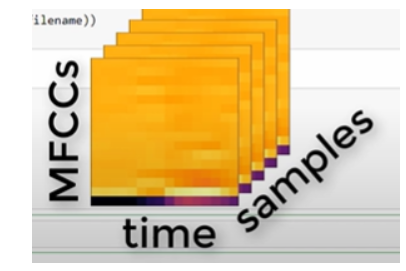

The first dim is the number of the data samples in the dataset. The second dim is the mfcc and the third is the number of sets in the coefficients

In [32]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(0,)
(0,)
(0,)


In [33]:
# View the dimensions of our input data
print(x_train.shape)

(0,)


# Understanding CNN
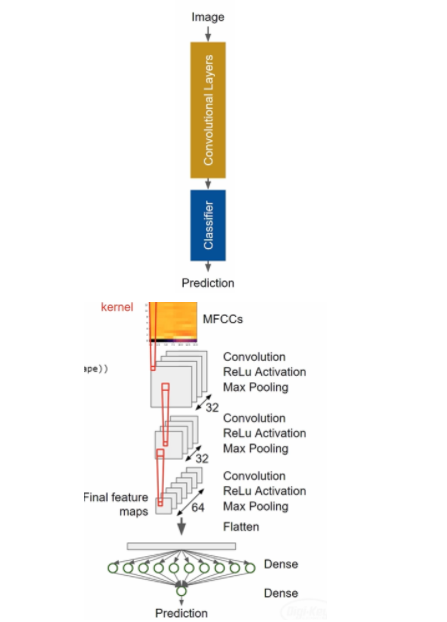

In [34]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

IndexError: tuple index out of range

dim=16. Tensorflow excepts the input tensors in a 4D as input to CNN. Specifically it want sample number, height, wdth, channel



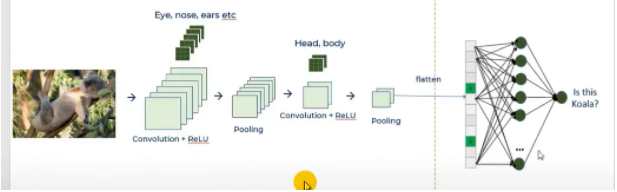

In [ ]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

In [ ]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()

#conv2d: reduce shape by 1 , reduce boundary
# number of neurons =32
# frame window=(2,2)
# activation= relu so that we have positive value
# input shape= tells the shape ofinput.
model.add(layers.Conv2D(32,(2, 2), activation='relu',input_shape=sample_shape))
# shape reduction 
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

#hidden layer 1
model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

#hidden layer 2
model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
#convert data to 1D so that next layer process will have small dim

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dropout(0.5))
#ignore random samples

model.add(layers.Dense(m, activation='softmax'))
#output layer

In [ ]:
# Display model
model.summary()

In [ ]:
# Add training hyperparameters to model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])

 #finding error,  devieation in the learning process             
#optimize the input weights by comparing the prediction and the loss function
#valuate the performance of  model

In [ ]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30,
                    batch_size=100, 
                    validation_data=(x_val, y_val))

In [ ]:
# Plot results

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the model as a file
models.save_model(model, model_filename)

In [ ]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(15, 20):
    #?????????????????????expand extra dimensions(adding channel). value:0
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))
    print()

In [ ]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

In [ ]:
ytesting = [0]

In [ ]:
xtesting = calc_mfcc('437455be_nohash_2.wav')

In [ ]:
answer = model.predict(np.expand_dims(xtesting, 0))

In [ ]:
print(answer)

In [ ]:
per_ans=[]
for x in range(len(answer[0])):
        per_ans.append( float("%.4f" % (answer[0][x]))*100)

In [ ]:
per_ans

In [ ]:
dict

In [ ]:
r=max(per_ans)
print()
print(dict[per_ans.index(max(per_ans))])
r

In [ ]:
if r<60:
    print("word was not spoken correctly please try aagin")